In [2]:
import numpy as np
import random
from copy import deepcopy
import networkx as nx
from matplotlib import pyplot as plt
import itertools
import timeit

In [3]:
def euclid_distance(u_x: float,
                    u_y: float,
                    v_x: float,
                    v_y: float) -> float:
    return np.sqrt((u_x - v_x)**2 + (u_y - v_y)**2)

In [4]:
def load_data(file_path: str) -> nx.Graph:
    with open(file_path, 'r') as f:
        g = nx.Graph()
        for line in f:
            if line[0].isdigit():
                node_id, x, y = [float(a) for a in line.split()]
                g.add_node(int(node_id) - 1, x=x, y=y)
        
        for u in range(len(g.nodes)):
            for v in range(u + 1, len(g.nodes)):
                
                weight = euclid_distance(g.nodes[u]['x'],
                                        g.nodes[u]['y'],
                                        g.nodes[v]['x'],
                                        g.nodes[v]['y'])
                
                g.add_edge(u, v, weight=weight)
                
        return g

In [5]:
def load_data_rs(file_path: str) -> nx.Graph:
    with open(file_path, 'r') as f:
        g = nx.Graph()
        for line in f:
            if line[0].isdigit():
                node_id, x, y, name, lp = [a for a in line.split()]
                
                g.add_node(int(node_id) - 1, x=float(x), y=float(y), name=name, lp=lp)
        
        for u in range(len(g.nodes)):
            for v in range(u + 1, len(g.nodes)):
                
                weight = euclid_distance(g.nodes[u]['x'],
                                        g.nodes[u]['y'],
                                        g.nodes[v]['x'],
                                        g.nodes[v]['y'])
                
                g.add_edge(u, v, weight=weight)
                
        return g

In [6]:
class Hamiltonian: 
    def __init__(self, g : nx.Graph):
        self.graph = deepcopy(g)
        self.cycle, self.fitness = self.initialize()

    def initialize(self):
        start = 0
        cycle = [start]
        visited = {start}
        u = start
        cycle_weight = 0
        g = self.graph
        
        while len(visited) != len(g.nodes):
            neighbours = [v for v in g[u] if v not in visited]
            chosen_neighbour = random.choices(neighbours, weights=None, k=1)[0]
            cycle.append(chosen_neighbour)
            visited.add(chosen_neighbour)
            cycle_weight += g[u][chosen_neighbour]['weight']
            u = chosen_neighbour
        
        cycle_weight += g[start][cycle[-1]]['weight']
        
        return cycle, cycle_weight
        
    def calcFitness(self):
        fitness = self.graph[self.cycle[0]][self.cycle[-1]]['weight']
        for u, v in zip(self.cycle[:-1], self.cycle[1:]):
            fitness += self.graph[u][v]['weight']
        self.fitness = fitness
        
    def bruteForce(self):
        best_fitness = self.fitness
        best_cycle = self.cycle
        permutations = itertools.permutations(self.cycle)
        
        for cycle in permutations:
            fitness = self.graph[cycle[0]][cycle[-1]]['weight']
            for u, v in zip(cycle[:-1], cycle[1:]):
                fitness += self.graph[u][v]['weight']
            
            if fitness < best_fitness:
                best_fitness = fitness
                best_cycle = cycle
        
        self.cycle = best_cycle
        self.fitness = best_fitness
        
        
    def __str__(self):
        return ' '.join([str(u) for u in self.cycle]) + f' {self.fitness}'
    
    def __getitem__(self, index):
        return self.cycle[index]

In [7]:
class SimulatedAnnealing(Hamiltonian):
    def __init__(self, graph : nx.Graph):
        super().__init__(graph)
    
    def swap(self): #swap place of two random cities
        a = random.randrange(len(self.cycle))
        b = random.randrange(len(self.cycle))
        
        self.cycle[a], self.cycle[b] = self.cycle[b], self.cycle[a]
        
        self.calcFitness()
    
    def optimizeMinusT(self,
                 num_iters: int,
                 end_fitness: float #0 if unknown
                 ):

        best_cycle = deepcopy(self.cycle)
        best_fitness = self.fitness
        fitnesses = [self.fitness]
        it = 1
        
        while (it < num_iters+1) and (end_fitness == 0 or (np.abs(best_fitness - end_fitness) > 0.1)):
            
            oldCycle, oldFitness = deepcopy(self.cycle), self.fitness
            self.swap()
            
            r = random.random()
            
            if self.fitness < oldFitness:
                if self.fitness < best_fitness:
                    best_fitness = self.fitness
                    best_cycle = deepcopy(self.cycle) #TODO optimize
            elif r > 1 / it:
                self.cycle = deepcopy(oldCycle)
                self.fitness = oldFitness
            
            
            fitnesses.append(best_fitness)
            #temperatures.append(temperature)
            it+=1
        
        #plt.plot(range(len(fitnesses)), fitnesses)
        #plt.show()
        #plt.plot(range(len(temperatures)), temperatures)
        #plt.show()
        
        self.cycle = deepcopy(best_cycle)
        self.fitness = best_fitness
        
        return fitnesses
            
    def optimize(self,
                 num_iters: int, 
                 T0: float,
                 fast_annealing: bool,
                 end_fitness: float, # 0 if unknown
                 ):

        best_cycle = deepcopy(self.cycle)
        best_fitness = self.fitness
        fitnesses = [self.fitness]
        #temperatures = [T0]
        temperature = T0
        it = 2
        
        while (it < num_iters+2) and (end_fitness == 0 or (np.abs(best_fitness - end_fitness) > 0.1)):
            
            oldCycle, oldFitness = deepcopy(self.cycle), self.fitness
            self.swap()
            
            r = random.random()
            
            if self.fitness < oldFitness:
                if self.fitness < best_fitness:
                    best_fitness = self.fitness
                    best_cycle = deepcopy(self.cycle) #TODO optimize
            elif r > np.exp(-(self.fitness - oldFitness) / temperature):
                self.cycle = deepcopy(oldCycle)
                self.fitness = oldFitness
            
            if fast_annealing == True:
                temperature = T0/it
            else:
                temperature = T0/np.log(it)
            
            fitnesses.append(best_fitness)
            #temperatures.append(temperature)
            
            it+=1
        
        #plt.plot(range(len(fitnesses)), fitnesses)
        #plt.show()
        #plt.plot(range(len(temperatures)), temperatures)
        #plt.show()
        
        self.cycle = deepcopy(best_cycle)
        self.fitness = best_fitness
        
        return fitnesses

In [8]:
class AdaptiveSimulatedAnnealing(Hamiltonian):
    def __init__(self, graph : nx.Graph):
        super().__init__(graph)
        
        
        self.setTuningParameters()
        self.initializeParameters()
        
    def setTuningParameters(self):  
        
        self.maxIters = 1000000
        self.reannealingRate = 10
        
        #Inberg defalut values
        self.temperature_ratio_scale = 0.00001
        self.temperature_anneal_scale = 100.0
        
        #values tested on dj38
        #self.temperature_ratio_scale = 0.5
        #self.temperature_anneal_scale = 500.0
        
        self.calculatec()
        
    
    def calculatec(self):
        
        self.m = -np.log(self.temperature_ratio_scale)
        self.n = np.log(self.temperature_anneal_scale)
        
        self.c = self.m * np.exp(-self.n / len(self.cycle))
    
    def initializeParameters(self):
        
        self.T0 = self.fitness
        self.Tcost = self.fitness
        self.Ti0 = [self.fitness] * len(self.cycle) #probabilities for sorted sequence, not generated
        self.Ti = [self.fitness] * len(self.cycle)
        
        self.acceptedPoints = 0 #k_cost in doc
        self.generatedPoints = [0] * len(self.cycle) #k_i in doc
        self.delta = [1] * len(self.cycle)
        
        self.best_cycle = deepcopy(self.cycle)
        self.best_fitness = self.fitness
    
    def swap(self): #swap place of two random cities
        
        a, b = random.choices(range(len(self.cycle)), weights = self.Ti, k=2)
        
        self.generatedPoints[a] += 1
        self.generatedPoints[b] += 1
        
        self.Ti[a] = self.Ti0[a] * np.exp(-self.c * self.generatedPoints[a]**(1 / len(self.cycle)))
        self.Ti[b] = self.Ti0[b] * np.exp(-self.c * self.generatedPoints[b]**(1 / len(self.cycle)))
        
        self.cycle[a], self.cycle[b] = self.cycle[b], self.cycle[a]
        
        self.calcFitness()
        
        return a, b
        
    
    def reannealing(self):
        self.fitness = self.best_fitness
        self.cycle = deepcopy(self.best_cycle)
        
        deltaMax = max(self.delta)
        
        for i in range(len(self.Ti)):
            if self.delta[i] >= 0.000001:
                self.Ti[i] = self.Ti[i]*(deltaMax/self.delta[i])
                
        for i in range(len(self.generatedPoints)):
            self.generatedPoints[i] = (np.log(self.Ti0[i]/self.Ti[i])/self.c)**len(self.cycle)
        
        #self.generatedPoints = [1] * len(self.cycle)
        
        self.acceptedPoints = 1
        self.T0 = Tcost = self.fitness 
        
        self.delta = [1] * len(self.cycle)
        
        
    
    def optimize(self, 
                 end_fitness : float #0 if its unknown
                ): 

        fitnesses = []
        #temperatures = []
        
        self.initializeParameters()
        it = 1
        
        while (it < self.maxIters+1) and (end_fitness == 0 or (np.abs(self.best_fitness - end_fitness) > 0.1)):
            
            if self.acceptedPoints % self.reannealingRate == 0:
                self.reannealing()
                
            oldCycle, oldFitness = deepcopy(self.cycle), self.fitness
            
            a, b = self.swap()
            
            r = random.random()
            
            if self.fitness < oldFitness:

                self.acceptedPoints += 1
                self.Tcost = self.T0 * np.exp(-self.c * self.acceptedPoints**(1 / len(self.cycle)))
                self.delta[a] = self.delta[b] = oldFitness - self.fitness 
                
                if self.fitness < self.best_fitness:
                    
                    self.best_fitness = self.fitness
                    self.best_cycle = deepcopy(self.cycle) 
            
            elif r < (np.exp(-(self.fitness - oldFitness)/self.Tcost)):
                
                self.acceptedPoints += 1
                self.Tcost = self.T0 * np.exp(-self.c * self.acceptedPoints**(1 / len(self.cycle)))
            
            else:
                
                self.cycle = deepcopy(oldCycle)
                self.fitness = oldFitness
            

            fitnesses.append(self.best_fitness)
            #temperatures.append(self.Tcost)
            
            it+=1
        
        #plt.plot(range(len(fitnesses)), fitnesses)
        #plt.show()
        #plt.plot(range(len(temperatures)), temperatures)
        #plt.show()
        
        self.cycle = deepcopy(self.best_cycle)
        self.fitness = self.best_fitness
        
        return fitnesses

In [9]:
def draw(g : nx.Graph,
         c : Hamiltonian,
         rs : bool): #tested
    edgeList = []
    for i in range(len(c.cycle)-1):
        edgeList.append((c.cycle[i], c.cycle[i+1]))
    edgeList.append((c.cycle[0], c.cycle[-1]))
    pos = {}
    labels = {}
    for u in g.nodes:
        x = g.nodes[u]['x'] /1000
        y = g.nodes[u]['y'] /1000
        pos[u] = (x,y)
        if rs:
            labels[u] = g.nodes[u]['lp']
        else:
            labels[u] = u
        
    nx.draw(g, edgelist = edgeList, pos=pos, labels = labels, with_labels = True, node_size=500,
            node_color='black', width=3, font_color = 'white', node_shape='o' )

In [11]:
rs5 = load_data_rs(file_path='rs5.tsp')
rs10 = load_data_rs(file_path='rs10.tsp')
rs15 = load_data_rs(file_path='rs15.tsp')

In [33]:
bruteforce5 = SimulatedAnnealing(rs5)
bruteforce10 = SimulatedAnnealing(rs10)
bruteforce15 = AdaptiveSimulatedAnnealing(rs15)

In [11]:
start = timeit.default_timer()
bruteforce5.bruteForce()
stop = timeit.default_timer()
print(f'Best cycle:{bruteforce5.cycle}\nBest fitness:{bruteforce5.fitness}\nTime:{stop-start}')

Best cycle:(3, 1, 4, 0, 2)
Best fitness:7287.430630882176
Time:0.0004889570409432054


In [12]:
start = timeit.default_timer()
bruteforce10.bruteForce()
stop = timeit.default_timer()
print(f'Best cycle:{bruteforce10.cycle}\nBest fitness:{bruteforce10.fitness}\nTime:{stop-start}')

Best cycle:(5, 9, 8, 0, 1, 4, 6, 3, 7, 2)
Best fitness:8799.828958445938
Time:22.266626008960884


In [35]:
bruteforce15.maxIters = 1000000
bruteforce15res = bruteforce15.optimize(0)

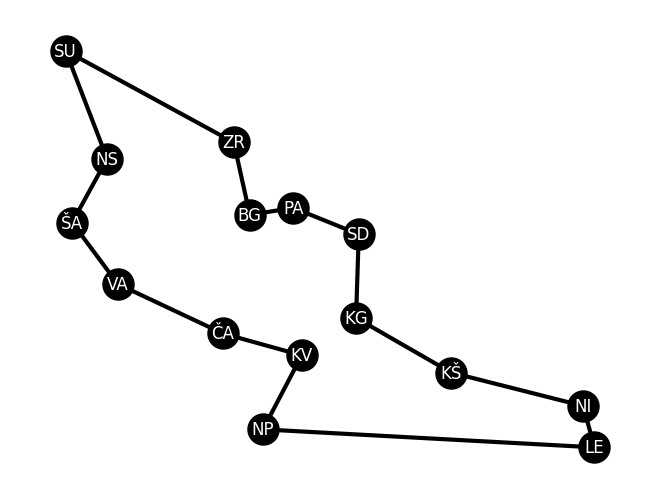

In [37]:
draw(g=rs15, c=bruteforce15, rs=True)

In [38]:
print(bruteforce15.fitness)

9254.30825070286


In [13]:
#Require 3months to compute
#start = timeit.default_timer()
#bruteforce15.bruteForce()
#stop = timeit.default_timer()
#print(f'Best cycle:{bruteforce15.cycle}\nBest fitness:{bruteforce15.fitness}\nTime:{stop-start}')

In [333]:
osnovni5 = SimulatedAnnealing(rs5)
osnovni10 = SimulatedAnnealing(rs10)
osnovni15 = SimulatedAnnealing(rs15)

In [278]:
start = timeit.default_timer()
osnovni5res = osnovni5.optimizeMinusT(num_iters=10000, end_fitness=7287.43)
stop = timeit.default_timer()
print(f'Best cycle:{osnovni5.cycle}\nBest fitness:{osnovni5.fitness}\nTime:{stop-start}')

Best cycle:[0, 4, 1, 3, 2]
Best fitness:7287.430630882177
Time:0.00017038400983437896


In [334]:
start = timeit.default_timer()
osnovni10res = osnovni10.optimizeMinusT(num_iters=10000000, end_fitness=8799.828)
stop = timeit.default_timer()
print(f'Best cycle:{osnovni10.cycle}\nBest fitness:{osnovni10.fitness}\nTime:{stop-start}')

Best cycle:[9, 8, 0, 1, 4, 6, 3, 7, 2, 5]
Best fitness:8799.82895844594
Time:0.0846081210183911


In [199]:
start = timeit.default_timer()
osnovni15res = osnovni15.optimizeMinusT(num_iters=10000000, end_fitness=9254.308)
stop = timeit.default_timer()
print(f'Best cycle:{osnovni15.cycle}\nBest fitness:{osnovni15.fitness}\nTime:{stop-start}')

Best cycle:[2, 7, 3, 13, 6, 0, 10, 4, 1, 12, 14, 11, 8, 9, 5]
Best fitness:9254.308250702858
Time:12.095940629951656


In [93]:
boltzmann5 = SimulatedAnnealing(rs5)
boltzmann10 = SimulatedAnnealing(rs10)
boltzmann15 = SimulatedAnnealing(rs15)

In [88]:
start = timeit.default_timer()
boltzmann5res=boltzmann5.optimize(num_iters=100000, T0=7287.43, fast_annealing=False, end_fitness=7287.43)
stop = timeit.default_timer()
print(f'Best cycle:{boltzmann5.cycle}\nBest fitness:{boltzmann5.fitness}\nTime:{stop-start}')

Best cycle:[4, 1, 3, 2, 0]
Best fitness:7287.430630882176
Time:0.00030805799178779125


In [99]:
start = timeit.default_timer()
boltzmann10res=boltzmann10.optimize(num_iters=10000000, T0=8799.828, fast_annealing=False, end_fitness=8799.828)
stop = timeit.default_timer()
print(f'Best cycle:{boltzmann10.cycle}\nBest fitness:{boltzmann10.fitness}\nTime:{stop-start}')

Best cycle:[9, 5, 2, 7, 3, 6, 4, 1, 0, 8]
Best fitness:8799.82895844594
Time:0.15216223400784656


In [94]:
start = timeit.default_timer()
boltzmann15res=boltzmann15.optimize(num_iters=10000000, T0=9254.308, fast_annealing=False, end_fitness=9254.308)
stop = timeit.default_timer()
print(f'Best cycle:{boltzmann15.cycle}\nBest fitness:{boltzmann15.fitness}\nTime:{stop-start}')

Best cycle:[0, 10, 4, 1, 12, 14, 11, 8, 9, 5, 2, 7, 3, 13, 6]
Best fitness:9254.308250702858
Time:23.93442939099623


In [267]:
fast5 = SimulatedAnnealing(rs5)
fast10 = SimulatedAnnealing(rs10)
fast15 = SimulatedAnnealing(rs15)

In [249]:
start = timeit.default_timer()
fast5res=fast5.optimize(num_iters=1000000, T0=7287.43, fast_annealing=True, end_fitness=7287.43)
stop = timeit.default_timer()
print(f'Best cycle:{fast5.cycle}\nBest fitness:{fast5.fitness}\nTime:{stop-start}')

Best cycle:[1, 4, 0, 2, 3]
Best fitness:7287.430630882177
Time:0.00014745997032150626


In [255]:
start = timeit.default_timer()
fast10res=fast10.optimize(num_iters=1000000, T0=8799.828, fast_annealing=True, end_fitness=8799.828)
stop = timeit.default_timer()
print(f'Best cycle:{fast10.cycle}\nBest fitness:{fast10.fitness}\nTime:{stop-start}')

Best cycle:[3, 6, 4, 1, 0, 8, 9, 5, 2, 7]
Best fitness:8799.82895844594
Time:0.010267559962812811


In [268]:
start = timeit.default_timer()
fast15res=fast15.optimize(num_iters=1000000, T0=9254.308, fast_annealing=True, end_fitness=9254.308)
stop = timeit.default_timer()
print(f'Best cycle:{fast15.cycle}\nBest fitness:{fast15.fitness}\nTime:{stop-start}')

Best cycle:[6, 13, 3, 7, 2, 5, 9, 8, 11, 14, 12, 1, 4, 10, 0]
Best fitness:9254.308250702858
Time:0.016819238022435457


In [341]:
adaptive5 = AdaptiveSimulatedAnnealing(rs5)
adaptive10 = AdaptiveSimulatedAnnealing(rs10)
adaptive15 = AdaptiveSimulatedAnnealing(rs15)

In [296]:
start = timeit.default_timer()
adaptive5res=adaptive5.optimize(end_fitness=7287.43)
stop = timeit.default_timer()
print(f'Best cycle:{adaptive5.cycle}\nBest fitness:{adaptive5.fitness}\nTime:{stop-start}')

Best cycle:[1, 3, 2, 0, 4]
Best fitness:7287.430630882178
Time:0.0003366899909451604


In [342]:
start = timeit.default_timer()
adaptive10res=adaptive10.optimize(end_fitness=8799.828)
stop = timeit.default_timer()
print(f'Best cycle:{adaptive10.cycle}\nBest fitness:{adaptive10.fitness}\nTime:{stop-start}')

Best cycle:[0, 1, 4, 6, 3, 7, 2, 5, 9, 8]
Best fitness:8799.82895844594
Time:0.003917554044164717


In [193]:
start = timeit.default_timer()
adaptive15.maxIters = 100000000
adaptive15res=adaptive15.optimize(end_fitness=9254.308)
stop = timeit.default_timer()
print(f'Best cycle:{adaptive15.cycle}\nBest fitness:{adaptive15.fitness}\nTime:{stop-start}')

Best cycle:[4, 10, 0, 6, 13, 3, 7, 2, 5, 9, 8, 11, 14, 12, 1]
Best fitness:9254.30825070286
Time:0.021663700987119228


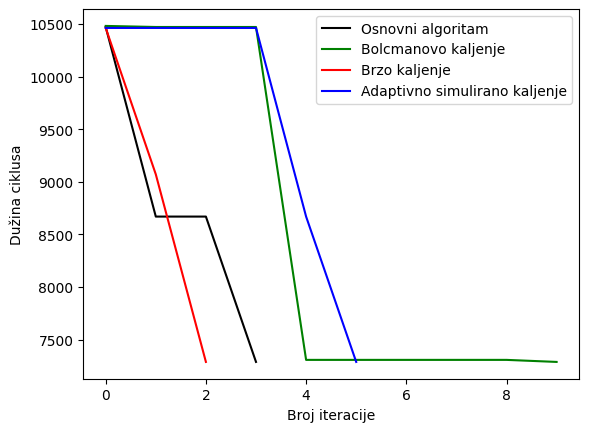

In [362]:
fig, ax = plt.subplots()
ax.plot(range(len(osnovni5res)), osnovni5res, color = 'black', label='Osnovni algoritam')
ax.plot(range(len(boltzmann5res)), boltzmann5res, color = 'green', label='Bolcmanovo kaljenje')
ax.plot(range(len(fast5res)), fast5res, color = 'red', label='Brzo kaljenje')
ax.plot(range(len(adaptive5res)), adaptive5res, color = 'blue', label='Adaptivno simulirano kaljenje')
ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')
plt.legend()
plt.show()

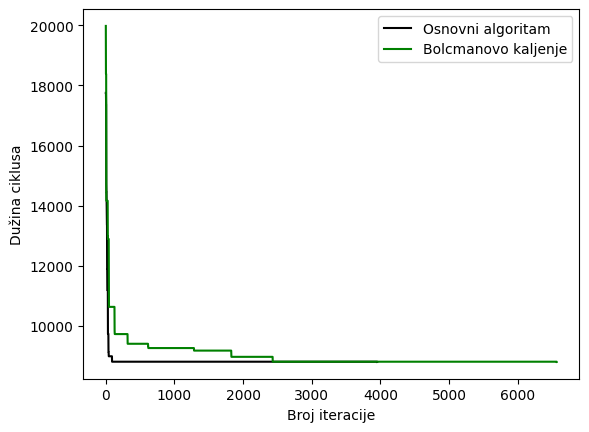

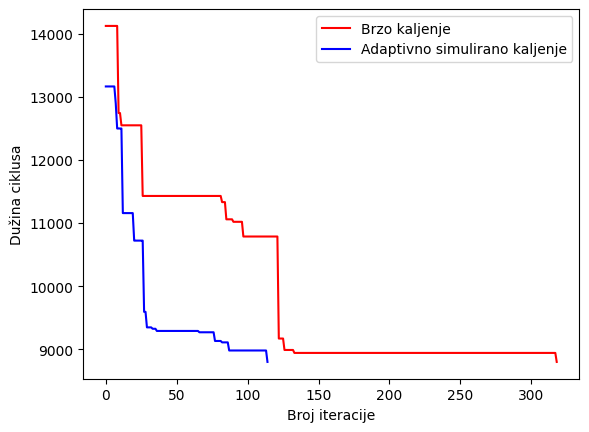

In [364]:
fig, ax = plt.subplots()
ax.plot(range(len(osnovni10res)), osnovni10res, color = 'black', label='Osnovni algoritam')
ax.plot(range(len(boltzmann10res)), boltzmann10res, color = 'green', label='Bolcmanovo kaljenje')
ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')
plt.legend()
plt.show()
fig, ax = plt.subplots()
ax.plot(range(len(fast10res)), fast10res, color = 'red', label='Brzo kaljenje')
ax.plot(range(len(adaptive10res)), adaptive10res, color = 'blue', label='Adaptivno simulirano kaljenje')
ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')
plt.legend()
plt.show()

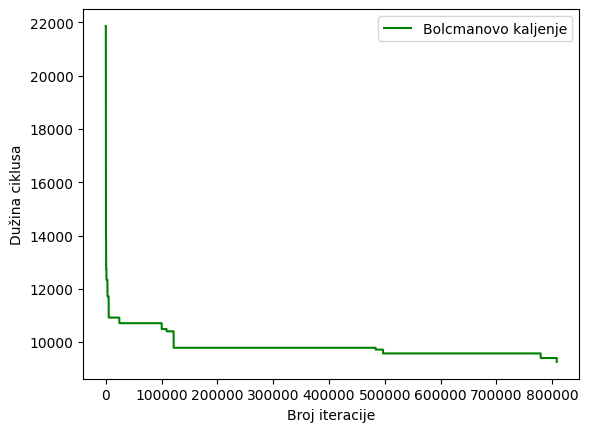

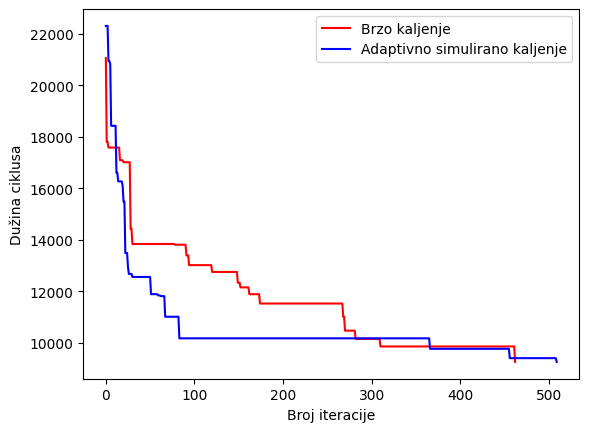

In [366]:
fig, ax = plt.subplots()
ax.plot(range(len(boltzmann15res)), boltzmann15res, color = 'green', label='Bolcmanovo kaljenje')
ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')
plt.legend()
plt.show()
fig, ax = plt.subplots()
ax.plot(range(len(fast15res)), fast15res, color = 'red', label='Brzo kaljenje')
ax.plot(range(len(adaptive15res)), adaptive15res, color = 'blue', label='Adaptivno simulirano kaljenje')
ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')
plt.legend()
plt.show()

In [16]:
djibuti = load_data(file_path='dj38.tsp')
sahara = load_data(file_path='wi29.tsp')
berlin = load_data(file_path='berlin52.tsp')

In [372]:
fastBerlin = SimulatedAnnealing(berlin)
start = timeit.default_timer()
fastBerlinRes = fastBerlin.optimize(num_iters=10000000, T0=1000, fast_annealing=True, end_fitness=0)
stop = timeit.default_timer()
print(f'Best cycle:{fastBerlin.cycle}\nBest fitness:{fastBerlin.fitness}\nTime:{stop-start}')

Best cycle:[25, 27, 24, 45, 47, 23, 4, 14, 37, 36, 39, 38, 35, 34, 33, 43, 15, 49, 19, 22, 28, 29, 20, 41, 1, 6, 16, 2, 17, 30, 21, 0, 48, 31, 44, 18, 40, 7, 8, 9, 32, 10, 51, 12, 50, 42, 5, 3, 11, 26, 13, 46]
Best fitness:9389.888170429636
Time:771.2805702399928


In [373]:
adaptiveBerlin = AdaptiveSimulatedAnnealing(berlin)
adaptiveBerlin.maxIters = 10000000
start = timeit.default_timer()
adaptiveBerlinRes = adaptiveBerlin.optimize(end_fitness=0)
stop = timeit.default_timer()
print(f'Best cycle:{adaptiveBerlin.cycle}\nBest fitness:{adaptiveBerlin.fitness}\nTime:{stop-start}')

Best cycle:[21, 0, 37, 4, 5, 3, 14, 2, 17, 20, 41, 1, 6, 16, 40, 18, 44, 31, 48, 38, 39, 23, 47, 36, 33, 43, 15, 49, 19, 28, 46, 25, 26, 10, 51, 13, 12, 27, 42, 7, 8, 9, 32, 50, 11, 24, 45, 35, 34, 22, 29, 30]
Best fitness:10450.23371481385
Time:840.6800785590312


============T=1.0==========================
Best cycle:[7, 8, 9, 42, 32, 26, 12, 13, 51, 10, 50, 11, 24, 3, 5, 37, 39, 21, 17, 2, 16, 30, 22, 20, 41, 6, 1, 46, 25, 27, 45, 4, 14, 23, 47, 36, 38, 33, 43, 15, 49, 28, 29, 19, 0, 34, 35, 48, 31, 44, 18, 40]
Best fitness:9900.671342847349
Time:7.972405795007944
============T=411.2307692307692==========================
Best cycle:[31, 38, 39, 37, 23, 4, 14, 5, 47, 36, 44, 18, 9, 8, 7, 40, 43, 46, 13, 51, 12, 26, 27, 11, 3, 24, 45, 15, 28, 49, 19, 22, 33, 34, 35, 48, 0, 21, 30, 20, 41, 6, 1, 29, 25, 10, 50, 32, 42, 2, 16, 17]
Best fitness:10577.177713533652
Time:7.775756554969121
============T=821.4615384615385==========================
Best cycle:[11, 27, 26, 10, 50, 42, 7, 40, 18, 44, 33, 43, 46, 25, 12, 13, 51, 32, 8, 9, 3, 24, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 48, 31, 20, 41, 6, 1, 29, 28, 49, 0, 21, 2, 16, 17, 30, 22, 19, 15, 45]
Best fitness:10676.176956476173
Time:7.725992923951708
============T=1231.6923076923076==============

============T=10667.0==========================
Best cycle:[22, 29, 1, 6, 41, 20, 16, 2, 18, 44, 42, 3, 5, 14, 4, 23, 37, 39, 38, 33, 43, 15, 49, 0, 31, 21, 30, 17, 40, 7, 8, 9, 32, 50, 10, 26, 25, 27, 11, 24, 47, 36, 35, 48, 34, 45, 46, 13, 51, 12, 28, 19]
Best fitness:9901.542585057006
Time:7.698507355991751
============T=11077.23076923077==========================
Best cycle:[0, 48, 34, 35, 8, 9, 5, 3, 27, 26, 24, 47, 36, 33, 38, 39, 37, 23, 4, 14, 44, 18, 7, 40, 2, 16, 20, 22, 43, 45, 11, 10, 50, 32, 42, 31, 21, 17, 30, 19, 49, 15, 28, 29, 41, 6, 1, 46, 13, 51, 12, 25]
Best fitness:11751.424360624618
Time:7.806442903995048
============T=11487.461538461539==========================
Best cycle:[20, 16, 2, 40, 7, 18, 44, 17, 21, 0, 48, 35, 34, 33, 36, 47, 37, 39, 38, 31, 8, 9, 32, 50, 10, 26, 27, 11, 42, 5, 3, 24, 25, 12, 51, 13, 46, 45, 15, 28, 1, 6, 41, 29, 49, 23, 4, 14, 43, 19, 22, 30]
Best fitness:10501.841129089878
Time:7.930537925974932
============T=11897.692307692307=========

=======trs 0.01===tas 100=====rr 10================
Best cycle:[42, 14, 4, 37, 39, 44, 18, 40, 7, 32, 50, 10, 51, 27, 11, 3, 5, 36, 38, 35, 48, 34, 33, 43, 45, 47, 23, 24, 25, 26, 12, 13, 46, 28, 15, 49, 19, 29, 22, 2, 16, 6, 1, 41, 20, 30, 17, 21, 0, 31, 8, 9]
Best fitness:10020.54363228332
Time:8.505927924998105
=======trs 0.01===tas 100=====rr 30================
Best cycle:[38, 35, 33, 43, 15, 28, 29, 20, 21, 0, 49, 19, 22, 30, 17, 31, 48, 34, 36, 47, 45, 24, 27, 26, 12, 51, 13, 25, 46, 1, 6, 41, 16, 2, 44, 42, 3, 11, 10, 50, 32, 9, 8, 7, 40, 18, 14, 5, 4, 23, 37, 39]
Best fitness:10094.687412286637
Time:8.506185953039676
=======trs 0.01===tas 100=====rr 50================
Best cycle:[8, 9, 32, 42, 14, 5, 24, 26, 12, 13, 51, 10, 50, 11, 3, 4, 23, 47, 45, 43, 34, 35, 33, 36, 37, 39, 38, 31, 17, 20, 30, 21, 48, 0, 22, 19, 49, 15, 27, 25, 46, 28, 29, 1, 6, 41, 16, 2, 44, 18, 40, 7]
Best fitness:9209.557469103034
Time:8.377455567999277
=======trs 0.01===tas 1000=====rr 10===============

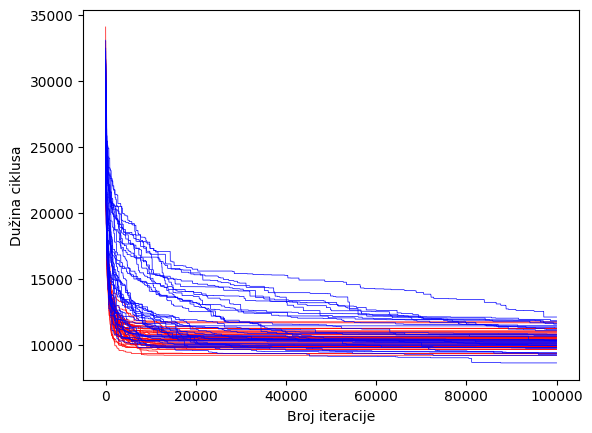

In [26]:
fig, ax = plt.subplots()
for T in np.linspace(1, 16000, 40):
    fastBerlin = SimulatedAnnealing(berlin)
    start = timeit.default_timer()
    fastBerlinRes = fastBerlin.optimize(num_iters=100000, T0=T, fast_annealing=True, end_fitness=0)
    stop = timeit.default_timer()
    print(f'============T={T}==========================')
    print(f'Best cycle:{fastBerlin.cycle}\nBest fitness:{fastBerlin.fitness}\nTime:{stop-start}')
    ax.plot(range(len(fastBerlinRes)), fastBerlinRes, color = 'red', lw=0.5)
    
for trs in (0.0001, 0.01, 0.1, 0.9):
    for tas in (10, 100, 1000):
        for rr in (10, 30, 50):
            
            adaptiveBerlin = AdaptiveSimulatedAnnealing(berlin)
            adaptiveBerlin.reannealingRate = rr
            adaptiveBerlin.temperature_ratio_scale = trs
            adaptiveBerlin.temperature_anneal_scale = tas
            adaptiveBerlin.calculatec()
            adaptiveBerlin.maxIters = 100000
            start = timeit.default_timer()
            adaptiveBerlinRes = adaptiveBerlin.optimize(end_fitness=0)
            stop = timeit.default_timer()
            print(f'=======trs {trs}===tas {tas}=====rr {rr}================')
            print(f'Best cycle:{adaptiveBerlin.cycle}\nBest fitness:{adaptiveBerlin.fitness}\nTime:{stop-start}')
            ax.plot(range(len(adaptiveBerlinRes)), adaptiveBerlinRes, color = 'blue', lw=0.5)

ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')

plt.show()

In [17]:
qa = load_data(file_path='qa194.tsp')

============T=1.0==========================
Best cycle:[107, 111, 114, 154, 177, 180, 183, 174, 152, 140, 118, 112, 108, 113, 149, 156, 164, 167, 176, 187, 190, 191, 188, 91, 63, 36, 38, 33, 31, 29, 34, 41, 49, 54, 74, 77, 102, 117, 120, 119, 127, 123, 122, 99, 72, 67, 65, 66, 60, 57, 46, 50, 76, 82, 137, 145, 141, 86, 70, 13, 10, 16, 20, 17, 23, 25, 73, 68, 59, 56, 44, 69, 78, 96, 105, 143, 153, 171, 175, 168, 163, 162, 155, 129, 110, 103, 79, 75, 71, 39, 43, 48, 53, 45, 47, 55, 80, 87, 125, 124, 100, 98, 93, 88, 81, 22, 6, 2, 32, 27, 21, 11, 9, 8, 4, 14, 18, 109, 128, 172, 185, 186, 189, 182, 166, 161, 158, 151, 146, 135, 134, 132, 142, 159, 184, 192, 193, 181, 178, 173, 130, 116, 115, 101, 35, 19, 64, 85, 97, 126, 131, 133, 139, 136, 90, 28, 26, 30, 37, 40, 42, 51, 52, 83, 121, 138, 160, 148, 144, 89, 84, 62, 61, 58, 0, 1, 3, 5, 7, 15, 12, 24, 92, 95, 94, 104, 150, 157, 169, 179, 170, 165, 147, 106]
Best fitness:21413.106583746438
Time:28.87063452700386
============T=513.79487179487

============T=4616.153846153847==========================
Best cycle:[56, 44, 38, 33, 30, 31, 34, 39, 46, 50, 59, 25, 23, 20, 17, 32, 83, 99, 109, 111, 107, 106, 104, 117, 157, 158, 164, 161, 159, 114, 72, 66, 65, 67, 76, 78, 172, 173, 178, 193, 189, 191, 192, 187, 190, 188, 183, 180, 169, 166, 167, 174, 182, 186, 185, 181, 175, 73, 68, 8, 9, 11, 71, 124, 131, 133, 125, 113, 75, 74, 77, 90, 118, 138, 137, 145, 153, 150, 154, 134, 119, 122, 123, 127, 132, 128, 120, 51, 53, 54, 49, 48, 45, 40, 37, 43, 41, 29, 18, 14, 4, 6, 10, 13, 79, 162, 160, 144, 126, 110, 22, 12, 15, 35, 89, 88, 92, 94, 91, 96, 95, 105, 115, 116, 130, 135, 142, 147, 146, 151, 140, 112, 108, 86, 101, 102, 121, 152, 156, 149, 143, 80, 60, 55, 52, 47, 42, 57, 63, 69, 87, 136, 139, 155, 168, 171, 163, 148, 141, 103, 100, 61, 58, 62, 84, 85, 97, 93, 98, 81, 70, 24, 7, 5, 16, 27, 36, 26, 28, 21, 2, 1, 3, 0, 19, 64, 129, 176, 177, 179, 184, 170, 165, 82]
Best fitness:21171.74303958189
Time:27.970855127030518
============T=5

============T=9231.307692307693==========================
Best cycle:[3, 1, 2, 4, 36, 67, 76, 78, 69, 32, 16, 13, 10, 6, 21, 28, 44, 63, 56, 59, 68, 73, 92, 146, 166, 169, 170, 157, 118, 81, 61, 58, 62, 89, 88, 121, 130, 135, 134, 128, 120, 116, 115, 114, 107, 106, 105, 136, 141, 148, 163, 171, 178, 185, 186, 182, 174, 172, 173, 144, 139, 133, 102, 95, 94, 82, 80, 46, 38, 33, 39, 40, 45, 47, 51, 52, 42, 25, 23, 20, 17, 8, 9, 11, 26, 57, 66, 154, 161, 167, 176, 180, 187, 190, 188, 191, 189, 193, 181, 175, 168, 162, 160, 145, 101, 77, 71, 74, 75, 108, 113, 125, 124, 131, 126, 110, 97, 85, 84, 64, 19, 35, 24, 27, 50, 60, 65, 99, 109, 111, 140, 151, 152, 149, 143, 138, 137, 153, 156, 164, 158, 150, 117, 104, 83, 72, 49, 34, 41, 54, 122, 123, 18, 14, 29, 31, 30, 37, 43, 48, 53, 55, 132, 147, 165, 159, 142, 127, 119, 112, 100, 98, 93, 103, 129, 155, 183, 192, 184, 179, 177, 96, 91, 87, 90, 86, 79, 70, 22, 12, 15, 7, 5, 0]
Best fitness:18904.769292984543
Time:29.048987157002557
============T=

============T=13846.461538461539==========================
Best cycle:[46, 59, 74, 100, 103, 69, 63, 76, 78, 80, 91, 146, 158, 157, 154, 134, 128, 116, 115, 111, 114, 122, 123, 127, 119, 99, 72, 52, 51, 47, 45, 42, 40, 48, 49, 54, 130, 135, 169, 179, 187, 190, 188, 163, 155, 129, 7, 5, 6, 23, 25, 68, 73, 77, 112, 131, 133, 125, 118, 104, 107, 106, 121, 140, 138, 102, 90, 82, 67, 33, 11, 9, 8, 50, 151, 180, 176, 177, 166, 161, 147, 142, 150, 156, 145, 148, 141, 144, 139, 136, 87, 65, 60, 55, 57, 56, 71, 81, 88, 98, 93, 89, 61, 58, 35, 62, 64, 19, 0, 3, 1, 2, 4, 14, 18, 120, 132, 159, 165, 170, 184, 192, 191, 189, 186, 193, 181, 175, 171, 173, 172, 174, 164, 167, 183, 182, 185, 178, 168, 162, 160, 137, 101, 92, 95, 94, 105, 96, 117, 143, 152, 153, 149, 109, 83, 66, 53, 43, 41, 29, 31, 26, 21, 17, 20, 27, 36, 38, 44, 32, 16, 13, 22, 24, 70, 75, 79, 86, 108, 113, 124, 126, 110, 97, 85, 84, 15, 12, 10, 28, 30, 34, 37, 39]
Best fitness:20319.53455818217
Time:28.693919058016036
============T=

============T=18461.615384615387==========================
Best cycle:[86, 74, 90, 92, 94, 95, 105, 104, 106, 107, 96, 91, 87, 82, 78, 80, 72, 67, 66, 60, 28, 27, 44, 63, 76, 101, 112, 136, 144, 155, 168, 171, 178, 173, 174, 158, 150, 135, 134, 132, 142, 159, 170, 166, 156, 153, 141, 145, 140, 151, 146, 128, 127, 123, 122, 125, 124, 131, 133, 139, 148, 160, 162, 163, 182, 186, 189, 191, 190, 192, 184, 119, 49, 34, 30, 26, 36, 50, 65, 83, 99, 109, 111, 176, 183, 180, 167, 157, 130, 117, 81, 62, 19, 64, 84, 85, 97, 93, 108, 116, 114, 115, 120, 147, 154, 165, 161, 121, 102, 69, 9, 8, 4, 2, 1, 0, 5, 7, 12, 10, 3, 6, 16, 71, 77, 118, 185, 193, 181, 175, 113, 61, 58, 35, 15, 22, 98, 100, 103, 110, 126, 137, 138, 143, 149, 152, 164, 169, 179, 177, 187, 188, 172, 129, 89, 88, 73, 54, 48, 41, 43, 53, 52, 51, 45, 31, 29, 18, 14, 11, 32, 68, 70, 24, 13, 23, 25, 20, 17, 21, 42, 55, 57, 46, 38, 33, 39, 37, 40, 47, 56, 59, 75, 79]
Best fitness:18951.348433087845
Time:28.793885777995456
============T

=======trs 0.0001===tas 100=====rr 50================
Best cycle:[0, 5, 7, 15, 73, 128, 134, 142, 147, 166, 167, 164, 163, 160, 162, 171, 178, 173, 172, 153, 94, 76, 60, 37, 30, 11, 9, 8, 14, 18, 29, 31, 34, 52, 72, 159, 165, 170, 169, 184, 179, 177, 192, 187, 190, 191, 189, 186, 185, 148, 139, 144, 155, 182, 188, 183, 174, 145, 133, 131, 126, 113, 66, 57, 55, 45, 47, 43, 40, 39, 33, 38, 68, 108, 112, 125, 124, 158, 154, 150, 146, 151, 152, 156, 168, 175, 181, 193, 180, 176, 161, 157, 135, 130, 117, 121, 118, 140, 149, 138, 137, 105, 96, 78, 67, 65, 36, 28, 27, 56, 44, 50, 46, 42, 51, 53, 54, 48, 49, 41, 26, 21, 17, 20, 32, 63, 80, 107, 106, 91, 82, 83, 99, 109, 111, 114, 115, 116, 120, 119, 123, 122, 127, 132, 104, 95, 92, 90, 101, 86, 79, 70, 71, 77, 74, 75, 81, 89, 93, 97, 110, 103, 100, 22, 24, 12, 4, 2, 1, 3, 6, 10, 13, 16, 25, 23, 59, 69, 87, 102, 143, 141, 136, 129, 98, 88, 61, 58, 35, 62, 84, 85, 64, 19]
Best fitness:17343.230230400542
Time:29.856205591000617
=======trs 0.0001=

=======trs 0.01===tas 100=====rr 50================
Best cycle:[80, 90, 77, 71, 53, 50, 63, 82, 86, 97, 58, 24, 20, 68, 23, 70, 131, 162, 163, 121, 112, 129, 175, 181, 185, 172, 137, 125, 108, 4, 16, 12, 22, 113, 126, 136, 148, 140, 83, 72, 30, 67, 106, 164, 153, 144, 160, 34, 41, 14, 31, 47, 51, 128, 120, 116, 122, 119, 114, 127, 123, 111, 88, 64, 84, 75, 101, 102, 91, 96, 135, 146, 166, 161, 132, 104, 105, 27, 36, 56, 94, 95, 142, 165, 117, 99, 66, 55, 40, 42, 17, 7, 10, 13, 15, 35, 19, 5, 0, 2, 46, 38, 49, 65, 118, 152, 151, 130, 134, 169, 177, 189, 193, 171, 186, 183, 178, 156, 149, 139, 85, 62, 93, 100, 103, 124, 133, 109, 69, 44, 57, 54, 52, 78, 154, 157, 150, 147, 159, 115, 107, 48, 8, 9, 11, 18, 37, 26, 28, 167, 174, 176, 191, 190, 180, 74, 3, 1, 6, 21, 29, 143, 138, 173, 168, 145, 155, 182, 188, 187, 179, 92, 87, 73, 79, 61, 81, 141, 184, 170, 192, 158, 110, 89, 98, 39, 33, 45, 43, 60, 32, 25, 59, 76]
Best fitness:33995.379655579745
Time:28.03807751496788
=======trs 0.01===tas

=======trs 0.1===tas 100=====rr 50================
Best cycle:[181, 193, 175, 173, 93, 35, 84, 62, 24, 141, 162, 163, 139, 108, 113, 110, 81, 94, 118, 101, 90, 153, 155, 126, 171, 178, 185, 103, 98, 89, 70, 79, 71, 42, 47, 34, 45, 22, 100, 157, 158, 151, 164, 146, 150, 128, 130, 159, 147, 142, 51, 31, 30, 7, 3, 6, 64, 85, 129, 144, 137, 117, 116, 99, 106, 119, 180, 183, 188, 184, 161, 154, 134, 127, 122, 18, 14, 4, 80, 83, 179, 177, 132, 48, 54, 67, 76, 91, 58, 61, 124, 149, 169, 170, 165, 114, 112, 65, 60, 66, 50, 36, 40, 43, 96, 135, 166, 111, 95, 88, 97, 131, 160, 133, 75, 8, 21, 20, 59, 63, 44, 78, 56, 28, 12, 0, 1, 9, 29, 49, 77, 86, 105, 87, 73, 68, 16, 11, 37, 41, 53, 33, 38, 25, 23, 92, 102, 191, 189, 186, 190, 192, 187, 176, 174, 182, 168, 115, 82, 72, 109, 167, 172, 74, 10, 13, 69, 32, 27, 52, 55, 57, 46, 39, 15, 19, 5, 2, 26, 17, 145, 138, 140, 156, 152, 121, 123, 120, 107, 104, 143, 136, 125, 148]
Best fitness:36335.38350002974
Time:25.28797237604158
=======trs 0.1===tas 10

/tmp/ipykernel_148831/2352505053.py:74: RuntimeWarning: overflow encountered in double_scalars
  self.generatedPoints[i] = (np.log(self.Ti0[i]/self.Ti[i])/self.c)**len(self.cycle)
/tmp/ipykernel_148831/2352505053.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  self.generatedPoints[i] = (np.log(self.Ti0[i]/self.Ti[i])/self.c)**len(self.cycle)


=======trs 0.9===tas 10=====rr 10================
Best cycle:[0, 81, 46, 66, 105, 35, 51, 191, 122, 93, 7, 47, 134, 14, 117, 129, 70, 192, 182, 123, 36, 114, 96, 40, 29, 101, 42, 76, 85, 121, 90, 130, 75, 115, 21, 136, 137, 88, 154, 108, 103, 102, 148, 140, 89, 80, 173, 67, 98, 69, 71, 91, 146, 50, 25, 24, 10, 152, 13, 38, 72, 82, 34, 180, 159, 33, 53, 63, 52, 48, 39, 56, 62, 171, 20, 3, 11, 111, 188, 15, 1, 54, 142, 186, 8, 143, 4, 109, 179, 158, 74, 113, 77, 190, 175, 167, 2, 144, 120, 128, 28, 112, 86, 23, 73, 87, 64, 65, 110, 30, 126, 79, 61, 99, 104, 68, 92, 106, 138, 185, 132, 5, 166, 156, 125, 9, 147, 60, 44, 163, 181, 164, 135, 45, 145, 161, 177, 151, 18, 31, 26, 153, 12, 119, 160, 118, 27, 100, 58, 107, 141, 55, 37, 17, 124, 97, 174, 149, 94, 183, 32, 43, 16, 83, 57, 49, 59, 176, 157, 172, 19, 187, 22, 84, 193, 78, 178, 184, 169, 139, 155, 131, 133, 95, 189, 6, 41, 170, 162, 150, 116, 165, 168, 127]
Best fitness:84613.78051145155
Time:30.24663142504869
=======trs 0.9===tas 10=

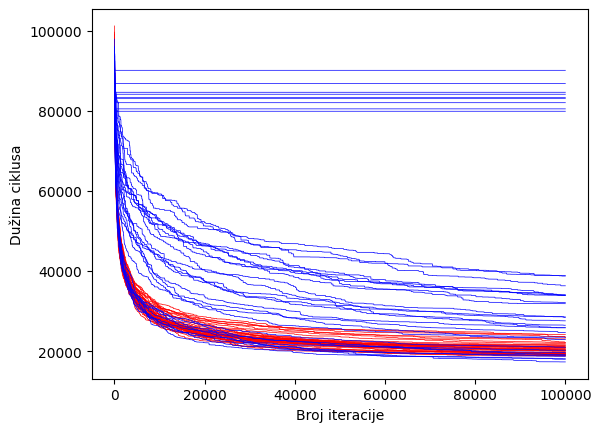

In [27]:
fig, ax = plt.subplots()
for T in np.linspace(1, 20000, 40):
    fastQatar = SimulatedAnnealing(qa)
    start = timeit.default_timer()
    fastQatarRes = fastQatar.optimize(num_iters=100000, T0=T, fast_annealing=True, end_fitness=0)
    stop = timeit.default_timer()
    print(f'============T={T}==========================')
    print(f'Best cycle:{fastQatar.cycle}\nBest fitness:{fastQatar.fitness}\nTime:{stop-start}')
    ax.plot(range(len(fastQatarRes)), fastQatarRes, color = 'red', lw=0.5)
    
for trs in (0.0001, 0.01, 0.1, 0.9):
    for tas in (10, 100, 1000):
        for rr in (10, 30, 50):
            
            adaptiveQatar = AdaptiveSimulatedAnnealing(qa)
            adaptiveQatar.reannealingRate = rr
            adaptiveQatar.temperature_ratio_scale = trs
            adaptiveQatar.temperature_anneal_scale = tas
            adaptiveQatar.calculatec()
            adaptiveQatar.maxIters = 100000
            start = timeit.default_timer()
            adaptiveQatarRes = adaptiveQatar.optimize(end_fitness=0)
            stop = timeit.default_timer()
            print(f'=======trs {trs}===tas {tas}=====rr {rr}================')
            print(f'Best cycle:{adaptiveQatar.cycle}\nBest fitness:{adaptiveQatar.fitness}\nTime:{stop-start}')
            ax.plot(range(len(adaptiveQatarRes)), adaptiveQatarRes, color = 'blue', lw=0.5)

ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')

plt.show()

In [11]:
zimbabwe = load_data('zi929.tsp')

============T=1.0==========================
Best cycle:[0, 14, 4, 19, 17, 29, 43, 39, 274, 342, 568, 605, 618, 663, 769, 764, 786, 831, 828, 597, 322, 203, 117, 118, 126, 158, 183, 392, 502, 538, 564, 530, 610, 640, 679, 736, 721, 707, 492, 407, 402, 401, 428, 544, 534, 563, 537, 343, 250, 83, 155, 134, 135, 114, 95, 98, 102, 518, 556, 555, 427, 400, 445, 443, 508, 535, 599, 725, 884, 897, 904, 845, 380, 286, 257, 639, 719, 704, 397, 436, 390, 437, 616, 687, 612, 494, 349, 279, 276, 237, 143, 145, 128, 132, 485, 456, 452, 476, 486, 453, 418, 517, 590, 686, 826, 800, 780, 761, 751, 738, 746, 735, 695, 449, 77, 62, 65, 150, 231, 241, 278, 658, 670, 757, 808, 805, 766, 785, 255, 246, 228, 210, 232, 223, 166, 164, 121, 325, 329, 596, 756, 767, 734, 731, 703, 672, 664, 665, 653, 693, 797, 815, 802, 898, 858, 646, 354, 362, 383, 924, 928, 926, 923, 900, 807, 768, 714, 691, 593, 581, 560, 594, 689, 717, 595, 603, 480, 463, 454, 491, 505, 740, 677, 683, 310, 242, 222, 190, 206, 327, 326, 434, 

============T=10257.358974358975==========================
Best cycle:[149, 158, 168, 166, 396, 438, 443, 456, 476, 440, 422, 285, 251, 58, 13, 10, 67, 339, 506, 518, 380, 310, 278, 298, 329, 351, 303, 14, 12, 44, 837, 895, 896, 885, 645, 827, 795, 816, 647, 744, 358, 332, 76, 30, 88, 463, 513, 530, 614, 601, 547, 504, 446, 473, 452, 423, 375, 292, 271, 300, 279, 295, 319, 833, 874, 879, 883, 863, 743, 561, 555, 607, 579, 370, 269, 132, 214, 185, 233, 294, 353, 723, 805, 800, 735, 749, 720, 712, 702, 612, 349, 328, 311, 334, 371, 368, 254, 253, 92, 296, 654, 776, 774, 797, 764, 733, 694, 696, 713, 693, 715, 768, 784, 758, 858, 891, 889, 820, 39, 43, 231, 197, 170, 121, 72, 40, 81, 31, 16, 162, 249, 412, 923, 924, 854, 623, 622, 600, 546, 567, 551, 544, 535, 560, 568, 350, 174, 217, 280, 322, 335, 330, 71, 42, 213, 223, 232, 655, 679, 691, 664, 708, 598, 577, 378, 377, 355, 324, 244, 80, 77, 7, 22, 17, 178, 64, 79, 317, 314, 318, 373, 651, 671, 643, 674, 587, 390, 293, 242, 192, 145, 11

============T=20513.71794871795==========================
Best cycle:[623, 634, 501, 310, 199, 180, 134, 157, 168, 195, 289, 639, 731, 746, 845, 913, 920, 907, 918, 883, 724, 692, 568, 557, 526, 339, 260, 132, 98, 116, 228, 252, 775, 771, 741, 736, 721, 695, 701, 700, 698, 635, 536, 525, 477, 452, 426, 434, 512, 576, 760, 871, 891, 796, 256, 264, 399, 478, 553, 564, 559, 534, 522, 438, 418, 413, 503, 490, 497, 647, 744, 842, 896, 642, 688, 804, 662, 593, 581, 545, 496, 484, 473, 521, 524, 604, 554, 546, 606, 609, 675, 667, 802, 783, 766, 715, 702, 669, 655, 800, 801, 834, 884, 794, 594, 584, 569, 547, 704, 707, 653, 651, 666, 251, 38, 36, 59, 26, 39, 40, 454, 430, 352, 281, 170, 139, 135, 208, 215, 184, 186, 185, 174, 123, 129, 106, 102, 265, 271, 73, 74, 159, 130, 79, 57, 100, 96, 377, 385, 382, 378, 376, 223, 216, 187, 193, 267, 295, 852, 869, 906, 909, 904, 792, 790, 770, 767, 769, 726, 620, 502, 486, 485, 468, 457, 475, 476, 112, 155, 162, 160, 142, 111, 25, 23, 272, 315, 303, 238,

============T=30770.076923076922==========================
Best cycle:[122, 114, 119, 142, 172, 181, 642, 742, 812, 818, 858, 837, 850, 649, 790, 758, 748, 680, 516, 523, 560, 686, 903, 893, 883, 873, 877, 628, 351, 131, 46, 148, 205, 221, 374, 904, 911, 922, 920, 902, 533, 321, 288, 514, 683, 783, 866, 839, 848, 675, 672, 345, 305, 244, 406, 440, 458, 572, 579, 541, 580, 704, 709, 699, 693, 684, 657, 62, 31, 18, 70, 126, 179, 252, 276, 263, 194, 207, 215, 239, 465, 744, 842, 836, 745, 821, 214, 185, 152, 168, 157, 169, 286, 323, 412, 380, 371, 409, 446, 455, 526, 513, 495, 443, 474, 484, 604, 614, 618, 617, 623, 602, 528, 500, 177, 158, 176, 154, 159, 248, 390, 658, 760, 750, 762, 782, 823, 856, 840, 867, 625, 759, 607, 584, 454, 419, 262, 97, 90, 180, 160, 136, 146, 199, 287, 308, 379, 466, 433, 426, 475, 447, 453, 418, 394, 376, 395, 420, 530, 539, 624, 794, 777, 587, 316, 234, 202, 208, 190, 320, 670, 674, 667, 397, 188, 167, 103, 42, 30, 15, 13, 101, 336, 332, 338, 383, 233, 227, 

============T=41026.4358974359==========================
Best cycle:[709, 422, 429, 410, 579, 651, 699, 731, 680, 116, 183, 51, 99, 517, 478, 486, 475, 530, 539, 708, 706, 716, 640, 590, 572, 498, 224, 216, 207, 186, 120, 127, 298, 514, 795, 851, 868, 928, 926, 923, 911, 887, 547, 531, 568, 518, 303, 306, 252, 185, 176, 145, 52, 53, 50, 44, 86, 130, 262, 101, 90, 71, 79, 64, 76, 61, 110, 128, 72, 26, 24, 23, 288, 171, 217, 154, 104, 156, 165, 147, 267, 275, 321, 328, 356, 368, 366, 408, 396, 394, 392, 393, 430, 471, 643, 657, 629, 825, 850, 824, 234, 114, 112, 367, 282, 92, 236, 343, 665, 650, 786, 784, 775, 875, 862, 449, 399, 395, 382, 270, 6, 27, 170, 197, 218, 463, 454, 492, 407, 327, 268, 253, 93, 7, 31, 17, 3, 4, 12, 22, 377, 398, 378, 331, 121, 232, 221, 215, 349, 625, 631, 638, 754, 820, 858, 628, 713, 436, 351, 309, 281, 260, 264, 493, 679, 704, 719, 634, 620, 497, 428, 458, 505, 637, 636, 844, 841, 797, 659, 669, 684, 758, 815, 859, 832, 870, 789, 778, 419, 403, 460, 459, 607

============T=51282.794871794875==========================
Best cycle:[619, 691, 709, 698, 722, 721, 704, 714, 363, 270, 51, 78, 168, 158, 115, 127, 181, 215, 226, 351, 596, 716, 686, 453, 466, 443, 433, 661, 623, 624, 546, 547, 470, 479, 478, 452, 524, 512, 763, 736, 660, 682, 640, 540, 498, 471, 430, 429, 431, 34, 15, 345, 428, 517, 567, 259, 20, 14, 18, 39, 21, 48, 87, 787, 723, 747, 753, 659, 656, 707, 650, 688, 692, 634, 586, 526, 593, 598, 706, 609, 569, 541, 448, 460, 416, 405, 394, 418, 475, 445, 537, 604, 614, 583, 566, 672, 741, 772, 635, 662, 605, 594, 761, 835, 890, 871, 695, 764, 806, 915, 911, 917, 877, 805, 751, 755, 730, 762, 728, 752, 765, 845, 873, 851, 864, 869, 548, 314, 83, 84, 326, 438, 473, 615, 641, 628, 823, 637, 647, 570, 557, 553, 581, 545, 469, 456, 521, 550, 777, 800, 844, 866, 868, 865, 846, 812, 782, 780, 750, 731, 727, 678, 676, 673, 667, 669, 703, 717, 732, 664, 493, 379, 197, 212, 160, 141, 206, 217, 247, 288, 370, 454, 461, 462, 506, 705, 773, 778, 79

============T=61539.153846153844==========================
Best cycle:[263, 199, 222, 108, 109, 120, 113, 59, 376, 505, 598, 706, 716, 873, 877, 893, 835, 804, 517, 497, 554, 504, 511, 456, 523, 560, 867, 597, 520, 362, 365, 204, 153, 180, 293, 367, 569, 605, 604, 623, 743, 863, 750, 587, 219, 94, 61, 3, 21, 84, 408, 429, 428, 427, 438, 305, 244, 324, 343, 401, 466, 473, 508, 522, 495, 485, 447, 86, 60, 44, 26, 274, 333, 396, 375, 574, 795, 632, 629, 628, 670, 703, 615, 584, 566, 567, 672, 704, 705, 607, 553, 439, 443, 426, 445, 911, 910, 829, 745, 822, 424, 724, 339, 548, 507, 307, 287, 338, 500, 449, 499, 546, 576, 594, 686, 707, 663, 320, 310, 205, 116, 112, 111, 78, 67, 589, 602, 611, 544, 538, 543, 476, 502, 417, 418, 326, 236, 1, 5, 297, 288, 247, 144, 142, 66, 50, 55, 359, 354, 347, 193, 214, 206, 226, 337, 370, 763, 781, 720, 717, 695, 675, 830, 726, 853, 861, 834, 764, 271, 12, 27, 38, 82, 121, 344, 419, 531, 556, 577, 590, 679, 696, 712, 644, 289, 252, 149, 160, 168, 150, 373

============T=71795.51282051283==========================
Best cycle:[155, 125, 120, 263, 311, 636, 820, 852, 817, 570, 646, 837, 842, 860, 829, 821, 819, 831, 876, 880, 761, 634, 726, 777, 686, 809, 808, 737, 668, 643, 645, 683, 752, 728, 676, 669, 642, 329, 238, 246, 613, 658, 677, 595, 586, 590, 872, 855, 519, 520, 178, 79, 64, 204, 105, 127, 94, 365, 383, 588, 908, 905, 372, 425, 374, 334, 289, 25, 21, 45, 81, 84, 1, 264, 354, 533, 338, 30, 19, 74, 109, 113, 197, 209, 243, 251, 260, 281, 297, 310, 210, 223, 302, 393, 443, 433, 486, 477, 492, 480, 468, 797, 802, 813, 832, 866, 849, 889, 918, 917, 903, 898, 877, 851, 846, 878, 899, 883, 835, 693, 700, 406, 401, 391, 403, 415, 386, 392, 388, 396, 531, 568, 541, 571, 576, 602, 584, 502, 495, 522, 521, 550, 559, 537, 515, 509, 435, 410, 102, 121, 111, 164, 112, 318, 569, 589, 607, 706, 650, 562, 351, 221, 234, 230, 189, 194, 207, 168, 170, 131, 26, 36, 37, 96, 697, 766, 790, 551, 510, 484, 467, 456, 381, 491, 517, 513, 488, 405, 461, 45

============T=82051.8717948718==========================
Best cycle:[869, 861, 857, 854, 815, 813, 613, 866, 831, 840, 828, 640, 582, 544, 535, 609, 736, 712, 760, 737, 734, 788, 628, 591, 179, 134, 136, 104, 143, 130, 100, 193, 319, 529, 472, 442, 353, 219, 170, 151, 160, 163, 171, 209, 230, 533, 287, 79, 34, 15, 20, 265, 556, 611, 794, 897, 898, 899, 907, 920, 913, 885, 849, 299, 329, 344, 340, 309, 249, 216, 164, 102, 284, 346, 81, 31, 24, 22, 493, 696, 778, 782, 826, 893, 890, 800, 363, 397, 821, 824, 779, 649, 323, 252, 54, 69, 89, 402, 384, 391, 414, 404, 403, 461, 498, 506, 527, 807, 795, 924, 927, 926, 891, 880, 839, 638, 625, 494, 632, 838, 817, 859, 871, 444, 508, 473, 534, 565, 563, 538, 566, 546, 540, 764, 805, 787, 464, 350, 231, 247, 245, 318, 430, 429, 387, 131, 88, 98, 128, 138, 195, 240, 232, 238, 330, 307, 291, 262, 290, 584, 515, 509, 495, 474, 522, 511, 510, 581, 554, 571, 659, 669, 699, 728, 715, 746, 781, 741, 587, 596, 77, 39, 7, 157, 148, 142, 141, 51, 43, 40, 9

============T=92308.23076923077==========================
Best cycle:[226, 278, 671, 660, 721, 712, 710, 750, 748, 645, 723, 627, 813, 786, 664, 610, 609, 571, 556, 601, 582, 599, 539, 555, 379, 260, 264, 364, 369, 823, 844, 909, 904, 894, 665, 650, 498, 462, 441, 416, 444, 509, 552, 553, 461, 431, 337, 131, 220, 223, 211, 187, 189, 125, 291, 277, 258, 263, 279, 648, 913, 907, 873, 870, 795, 320, 30, 47, 56, 275, 328, 372, 829, 822, 860, 850, 899, 915, 897, 593, 554, 478, 479, 518, 778, 746, 775, 797, 805, 806, 807, 802, 783, 632, 336, 322, 280, 252, 228, 202, 247, 243, 325, 318, 472, 820, 926, 918, 883, 872, 683, 818, 649, 575, 638, 646, 729, 688, 704, 705, 398, 386, 541, 526, 492, 611, 635, 634, 804, 707, 691, 432, 450, 370, 342, 340, 677, 669, 696, 654, 587, 297, 68, 91, 120, 205, 217, 529, 922, 927, 890, 863, 738, 749, 692, 532, 471, 481, 558, 839, 852, 875, 888, 914, 908, 845, 832, 814, 811, 865, 864, 924, 925, 920, 576, 536, 497, 476, 466, 473, 495, 489, 517, 662, 633, 730, 722, 

============T=102564.58974358975==========================
Best cycle:[745, 819, 779, 821, 863, 810, 617, 581, 565, 538, 515, 486, 343, 83, 87, 84, 642, 737, 697, 677, 361, 252, 105, 90, 75, 204, 494, 630, 823, 864, 873, 846, 613, 369, 208, 193, 118, 115, 125, 88, 132, 587, 610, 634, 620, 843, 853, 838, 844, 858, 852, 529, 542, 625, 372, 328, 237, 169, 148, 142, 127, 156, 159, 280, 631, 833, 885, 896, 889, 892, 891, 872, 723, 645, 847, 883, 813, 803, 800, 780, 769, 778, 773, 767, 727, 657, 290, 239, 231, 166, 163, 202, 189, 207, 291, 649, 837, 626, 321, 349, 374, 294, 299, 368, 579, 594, 662, 897, 887, 563, 534, 522, 893, 916, 920, 922, 927, 312, 201, 196, 192, 225, 860, 867, 874, 871, 733, 739, 738, 703, 681, 669, 673, 562, 286, 219, 168, 171, 95, 63, 38, 16, 77, 378, 392, 393, 480, 596, 839, 876, 856, 729, 641, 490, 525, 589, 603, 609, 804, 650, 718, 694, 656, 652, 569, 557, 584, 601, 624, 830, 835, 805, 859, 894, 848, 483, 303, 304, 314, 345, 470, 415, 394, 382, 397, 687, 637, 855, 

============T=112820.94871794872==========================
Best cycle:[778, 689, 782, 738, 781, 763, 750, 767, 756, 770, 740, 797, 775, 732, 370, 136, 119, 103, 135, 176, 137, 134, 101, 79, 178, 287, 839, 823, 450, 430, 498, 506, 702, 765, 592, 411, 285, 500, 587, 683, 742, 786, 733, 594, 539, 551, 608, 631, 831, 850, 885, 913, 915, 910, 909, 857, 455, 419, 410, 298, 294, 229, 131, 293, 265, 442, 803, 788, 792, 811, 646, 866, 825, 759, 369, 184, 206, 228, 202, 221, 241, 245, 367, 573, 679, 804, 777, 620, 606, 524, 523, 543, 513, 460, 492, 897, 917, 905, 744, 636, 371, 309, 304, 351, 869, 914, 900, 821, 533, 359, 347, 332, 50, 44, 72, 78, 596, 644, 652, 653, 464, 252, 240, 210, 212, 218, 437, 574, 627, 760, 661, 624, 623, 884, 887, 863, 853, 707, 643, 284, 23, 21, 40, 77, 80, 217, 207, 194, 157, 170, 85, 87, 83, 395, 431, 610, 650, 570, 424, 273, 261, 272, 260, 331, 441, 516, 476, 467, 466, 443, 559, 599, 618, 581, 536, 531, 408, 398, 388, 389, 409, 416, 477, 447, 446, 440, 405, 399, 29

============T=123077.30769230769==========================
Best cycle:[0, 19, 12, 38, 50, 60, 883, 899, 875, 866, 754, 548, 301, 213, 84, 85, 292, 651, 712, 733, 764, 737, 756, 870, 810, 725, 618, 561, 536, 393, 259, 11, 6, 8, 18, 51, 348, 377, 382, 404, 441, 430, 448, 337, 273, 163, 174, 154, 159, 322, 365, 359, 347, 332, 330, 824, 759, 874, 901, 920, 918, 894, 823, 148, 171, 188, 424, 925, 922, 872, 835, 834, 854, 248, 220, 197, 117, 120, 130, 165, 185, 202, 218, 490, 403, 392, 394, 562, 587, 240, 238, 241, 228, 230, 183, 201, 215, 208, 179, 136, 139, 151, 249, 300, 848, 886, 885, 865, 846, 868, 862, 860, 362, 311, 317, 323, 364, 334, 329, 371, 803, 747, 811, 628, 370, 363, 436, 481, 501, 675, 697, 694, 724, 718, 783, 765, 807, 753, 739, 735, 780, 784, 863, 853, 661, 545, 581, 550, 559, 439, 426, 447, 384, 381, 253, 250, 92, 87, 83, 67, 465, 529, 744, 856, 869, 888, 876, 575, 233, 192, 169, 175, 113, 123, 198, 356, 353, 369, 412, 390, 324, 305, 244, 343, 420, 547, 698, 658, 645, 855,

============T=133333.66666666666==========================
Best cycle:[304, 260, 269, 839, 820, 888, 914, 908, 290, 252, 221, 184, 187, 137, 162, 231, 748, 757, 792, 788, 848, 319, 192, 181, 172, 186, 288, 772, 782, 799, 847, 865, 723, 560, 515, 495, 509, 445, 444, 401, 384, 458, 447, 428, 459, 641, 706, 679, 449, 21, 40, 83, 378, 388, 581, 614, 623, 611, 634, 574, 325, 102, 86, 38, 54, 104, 117, 156, 173, 179, 216, 218, 258, 262, 101, 75, 57, 47, 29, 97, 94, 287, 308, 358, 354, 645, 715, 728, 766, 718, 704, 680, 667, 656, 817, 840, 822, 588, 549, 222, 211, 214, 225, 234, 228, 196, 227, 233, 203, 255, 578, 646, 687, 823, 765, 711, 708, 607, 615, 635, 662, 743, 584, 594, 602, 571, 525, 561, 566, 546, 862, 842, 819, 821, 612, 504, 457, 511, 777, 922, 918, 915, 910, 835, 655, 627, 334, 237, 42, 34, 76, 338, 359, 520, 239, 198, 248, 435, 443, 433, 617, 512, 487, 488, 716, 692, 749, 760, 756, 878, 864, 315, 88, 44, 37, 103, 135, 210, 245, 803, 742, 481, 243, 169, 124, 126, 118, 147, 120, 11

============T=143590.02564102566==========================
Best cycle:[905, 895, 850, 588, 824, 626, 135, 134, 140, 175, 260, 386, 404, 428, 427, 459, 470, 571, 568, 593, 620, 615, 623, 510, 522, 484, 438, 521, 534, 537, 515, 343, 99, 132, 219, 397, 378, 388, 394, 402, 406, 413, 420, 719, 778, 424, 323, 58, 61, 30, 10, 19, 24, 48, 92, 87, 83, 250, 84, 85, 268, 259, 749, 789, 910, 916, 917, 904, 877, 790, 814, 818, 903, 909, 918, 924, 891, 896, 825, 744, 852, 613, 591, 483, 365, 347, 332, 203, 222, 257, 262, 372, 625, 796, 855, 833, 817, 857, 887, 897, 763, 639, 455, 377, 327, 296, 361, 472, 482, 773, 780, 769, 738, 843, 853, 685, 545, 524, 539, 684, 697, 167, 163, 181, 266, 668, 645, 368, 306, 9, 2, 3, 22, 313, 236, 254, 253, 271, 229, 170, 150, 51, 23, 337, 596, 811, 795, 364, 334, 108, 105, 130, 143, 221, 190, 241, 501, 652, 665, 641, 550, 559, 529, 358, 275, 215, 184, 169, 189, 213, 223, 224, 228, 374, 578, 872, 873, 859, 844, 302, 212, 198, 211, 63, 35, 13, 56, 47, 280, 465, 592, 7

============T=153846.38461538462==========================
Best cycle:[146, 181, 19, 0, 87, 283, 67, 137, 139, 152, 228, 320, 728, 762, 768, 747, 910, 907, 913, 894, 901, 923, 926, 928, 889, 796, 867, 902, 886, 882, 860, 625, 349, 317, 187, 153, 425, 869, 845, 818, 742, 792, 14, 38, 91, 180, 174, 135, 148, 164, 223, 238, 234, 241, 356, 573, 527, 524, 484, 473, 474, 511, 467, 444, 305, 92, 83, 84, 48, 41, 80, 99, 284, 200, 314, 102, 144, 141, 155, 157, 210, 286, 465, 412, 642, 644, 826, 830, 777, 725, 552, 510, 515, 523, 618, 623, 794, 863, 887, 736, 721, 610, 555, 550, 534, 508, 563, 581, 554, 579, 719, 714, 682, 331, 259, 254, 244, 399, 419, 713, 752, 739, 749, 733, 712, 701, 574, 529, 542, 840, 822, 359, 347, 365, 275, 147, 109, 124, 159, 173, 179, 390, 514, 570, 740, 715, 656, 677, 657, 436, 380, 817, 915, 911, 904, 912, 621, 372, 328, 222, 123, 88, 16, 11, 22, 6, 82, 95, 106, 111, 31, 23, 93, 454, 462, 879, 880, 874, 837, 588, 575, 424, 250, 236, 253, 549, 597, 626, 519, 321, 263, 

============T=164102.7435897436==========================
Best cycle:[37, 33, 28, 58, 143, 159, 173, 222, 255, 302, 628, 688, 680, 655, 416, 352, 376, 518, 547, 431, 395, 313, 40, 39, 285, 390, 437, 899, 913, 844, 542, 483, 882, 885, 922, 920, 925, 894, 904, 864, 838, 823, 217, 194, 208, 215, 207, 206, 203, 277, 358, 338, 519, 600, 552, 510, 474, 495, 563, 564, 663, 826, 789, 775, 809, 803, 802, 227, 225, 181, 193, 185, 186, 163, 144, 160, 162, 139, 135, 205, 234, 231, 219, 432, 611, 602, 593, 556, 441, 463, 270, 65, 131, 265, 360, 410, 398, 506, 493, 271, 261, 233, 97, 291, 322, 321, 500, 590, 605, 618, 793, 726, 787, 529, 533, 332, 34, 104, 146, 120, 55, 52, 9, 0, 6, 26, 132, 424, 645, 586, 531, 598, 589, 716, 708, 704, 751, 698, 150, 164, 103, 155, 142, 136, 257, 825, 895, 886, 927, 890, 863, 607, 526, 532, 309, 243, 184, 115, 154, 204, 287, 101, 91, 70, 2, 13, 29, 161, 165, 105, 60, 69, 122, 124, 63, 292, 433, 451, 614, 622, 342, 18, 22, 51, 46, 192, 246, 374, 875, 858, 765, 790, 7

============T=174359.10256410256==========================
Best cycle:[134, 233, 334, 866, 869, 892, 889, 916, 883, 792, 768, 789, 808, 718, 748, 834, 620, 427, 428, 314, 285, 103, 136, 181, 597, 822, 824, 649, 621, 472, 432, 499, 505, 518, 700, 701, 684, 694, 766, 702, 836, 779, 533, 519, 307, 42, 29, 47, 322, 872, 878, 832, 813, 264, 59, 32, 16, 22, 382, 394, 404, 600, 624, 623, 502, 333, 346, 313, 342, 528, 655, 696, 653, 695, 663, 686, 635, 751, 802, 570, 482, 450, 449, 471, 489, 524, 522, 582, 614, 661, 861, 854, 633, 565, 438, 305, 326, 324, 343, 491, 794, 870, 881, 791, 693, 697, 733, 710, 698, 713, 699, 591, 64, 76, 79, 208, 226, 329, 737, 734, 720, 712, 709, 650, 590, 589, 531, 546, 417, 477, 445, 444, 619, 804, 781, 907, 913, 923, 896, 494, 58, 13, 19, 143, 130, 204, 101, 258, 257, 323, 501, 644, 735, 782, 769, 780, 772, 763, 480, 431, 463, 672, 704, 721, 757, 687, 636, 437, 371, 411, 464, 786, 785, 800, 799, 703, 260, 269, 137, 113, 174, 154, 146, 190, 193, 194, 218, 302, 27

============T=184615.46153846153==========================
Best cycle:[751, 767, 771, 248, 210, 136, 163, 142, 119, 203, 91, 60, 59, 80, 313, 526, 603, 640, 641, 639, 276, 233, 174, 165, 154, 159, 173, 293, 341, 376, 370, 754, 648, 213, 235, 197, 252, 320, 669, 673, 390, 310, 172, 152, 230, 325, 422, 530, 535, 539, 565, 604, 600, 551, 545, 468, 453, 254, 92, 84, 45, 74, 144, 183, 170, 306, 379, 419, 392, 430, 692, 761, 760, 774, 667, 493, 339, 236, 327, 404, 480, 783, 813, 811, 558, 542, 548, 588, 549, 519, 383, 824, 882, 587, 385, 381, 326, 324, 445, 614, 810, 661, 589, 577, 527, 528, 610, 586, 590, 598, 623, 624, 463, 455, 397, 436, 243, 245, 82, 68, 54, 46, 67, 337, 386, 382, 393, 435, 479, 541, 572, 562, 819, 779, 850, 837, 831, 822, 821, 626, 862, 856, 514, 298, 251, 232, 234, 227, 262, 845, 877, 775, 739, 697, 674, 723, 494, 334, 240, 205, 215, 188, 167, 175, 226, 241, 297, 351, 411, 872, 865, 868, 889, 888, 841, 815, 790, 770, 748, 772, 763, 804, 843, 568, 504, 462, 700, 800, 89

============T=194871.82051282053==========================
Best cycle:[148, 171, 344, 342, 562, 855, 842, 831, 828, 779, 311, 277, 204, 104, 118, 98, 68, 60, 52, 166, 212, 288, 587, 493, 373, 31, 24, 48, 352, 430, 423, 379, 316, 369, 542, 616, 592, 470, 428, 406, 417, 525, 708, 707, 577, 560, 581, 565, 534, 346, 345, 382, 378, 348, 333, 285, 255, 240, 237, 174, 173, 179, 217, 247, 494, 637, 744, 358, 372, 349, 257, 183, 325, 498, 506, 518, 572, 579, 585, 722, 775, 702, 673, 464, 232, 223, 210, 224, 220, 170, 96, 89, 85, 473, 535, 521, 516, 487, 431, 448, 632, 558, 412, 276, 42, 56, 279, 312, 570, 639, 682, 714, 738, 736, 741, 721, 710, 757, 864, 907, 921, 926, 287, 79, 76, 143, 133, 176, 298, 387, 410, 408, 421, 456, 495, 484, 474, 551, 539, 524, 538, 566, 763, 749, 720, 772, 416, 403, 392, 388, 6, 9, 29, 116, 77, 93, 343, 244, 324, 305, 231, 295, 317, 745, 821, 833, 849, 896, 928, 924, 897, 881, 436, 353, 157, 138, 107, 128, 141, 119, 167, 209, 293, 432, 455, 454, 441, 527, 540, 647, 

/tmp/ipykernel_151478/2352505053.py:53: RuntimeWarning: invalid value encountered in double_scalars
  self.Ti[a] = self.Ti0[a] * np.exp(-self.c * self.generatedPoints[a]**(1 / len(self.cycle)))
/tmp/ipykernel_151478/2352505053.py:54: RuntimeWarning: invalid value encountered in double_scalars
  self.Ti[b] = self.Ti0[b] * np.exp(-self.c * self.generatedPoints[b]**(1 / len(self.cycle)))


=======trs 0.0001===tas 10=====rr 10================
Best cycle:[0, 92, 174, 377, 827, 162, 883, 81, 147, 828, 559, 48, 172, 864, 213, 157, 869, 448, 144, 371, 752, 187, 699, 760, 22, 454, 576, 850, 824, 509, 788, 327, 690, 107, 655, 17, 839, 469, 279, 749, 121, 204, 10, 178, 446, 713, 6, 119, 915, 312, 233, 805, 830, 101, 802, 649, 925, 717, 125, 800, 724, 874, 283, 415, 741, 548, 229, 813, 177, 846, 366, 498, 59, 519, 795, 927, 904, 595, 785, 639, 344, 837, 417, 89, 769, 645, 660, 269, 687, 698, 581, 684, 432, 72, 286, 798, 771, 110, 215, 514, 550, 893, 135, 74, 816, 527, 223, 289, 809, 732, 321, 468, 337, 200, 560, 692, 697, 913, 385, 782, 131, 452, 221, 355, 572, 297, 71, 588, 12, 373, 116, 234, 335, 69, 858, 203, 546, 794, 844, 756, 745, 244, 736, 264, 462, 602, 273, 349, 668, 895, 347, 158, 715, 86, 150, 30, 578, 746, 218, 757, 93, 855, 534, 73, 40, 553, 256, 521, 112, 506, 108, 175, 58, 247, 15, 386, 528, 32, 146, 325, 818, 455, 500, 176, 76, 768, 631, 155, 888, 487, 41, 160, 18

=======trs 0.0001===tas 10=====rr 50================
Best cycle:[907, 286, 345, 875, 333, 835, 681, 335, 890, 454, 911, 794, 194, 917, 317, 94, 353, 295, 468, 178, 7, 877, 220, 693, 870, 412, 528, 337, 327, 146, 650, 63, 791, 109, 236, 484, 173, 159, 589, 839, 392, 837, 184, 280, 542, 716, 5, 448, 88, 539, 554, 669, 504, 163, 606, 216, 633, 815, 524, 375, 891, 371, 26, 28, 761, 771, 479, 750, 185, 73, 190, 801, 50, 834, 68, 754, 548, 143, 389, 141, 541, 385, 526, 612, 347, 297, 821, 753, 755, 643, 425, 298, 621, 872, 595, 812, 587, 686, 800, 319, 848, 850, 778, 279, 106, 20, 437, 630, 513, 478, 177, 307, 160, 491, 830, 66, 736, 673, 457, 435, 404, 546, 607, 261, 241, 328, 115, 278, 144, 340, 543, 739, 110, 532, 275, 466, 464, 868, 56, 557, 426, 765, 502, 423, 284, 782, 899, 453, 522, 489, 470, 876, 362, 789, 259, 525, 923, 903, 271, 219, 71, 922, 442, 365, 722, 344, 822, 369, 87, 411, 712, 896, 304, 511, 407, 388, 18, 841, 283, 167, 764, 65, 302, 358, 880, 914, 373, 629, 499, 798, 98, 

/tmp/ipykernel_151478/2352505053.py:74: RuntimeWarning: overflow encountered in double_scalars
  self.generatedPoints[i] = (np.log(self.Ti0[i]/self.Ti[i])/self.c)**len(self.cycle)


=======trs 0.0001===tas 100=====rr 30================
Best cycle:[0, 141, 362, 637, 789, 797, 457, 482, 125, 896, 211, 623, 288, 103, 147, 152, 90, 417, 258, 753, 611, 216, 703, 620, 446, 419, 281, 127, 246, 754, 398, 762, 629, 52, 299, 839, 82, 679, 22, 286, 150, 65, 701, 822, 597, 198, 812, 485, 685, 349, 352, 659, 502, 432, 162, 115, 222, 321, 556, 4, 335, 779, 599, 910, 733, 805, 868, 533, 747, 489, 168, 184, 806, 661, 255, 28, 214, 827, 356, 880, 465, 630, 873, 484, 89, 114, 47, 914, 120, 563, 346, 523, 434, 31, 478, 330, 32, 178, 697, 305, 594, 451, 668, 276, 758, 182, 565, 604, 238, 546, 454, 920, 525, 1, 877, 781, 576, 544, 87, 535, 527, 595, 206, 37, 266, 658, 135, 208, 716, 441, 282, 269, 137, 922, 123, 422, 351, 43, 382, 34, 91, 590, 848, 538, 722, 865, 435, 909, 653, 109, 97, 869, 14, 55, 228, 94, 828, 796, 336, 23, 788, 223, 74, 316, 663, 319, 445, 339, 326, 45, 566, 360, 132, 681, 107, 209, 450, 452, 156, 737, 889, 745, 857, 166, 96, 315, 479, 518, 358, 724, 516, 403, 682

=======trs 0.0001===tas 1000=====rr 10================
Best cycle:[0, 441, 3, 117, 485, 329, 106, 842, 925, 728, 508, 631, 250, 30, 389, 618, 918, 661, 488, 63, 685, 754, 353, 74, 216, 136, 597, 351, 430, 510, 266, 626, 869, 50, 621, 527, 54, 767, 633, 431, 638, 176, 758, 309, 332, 391, 684, 494, 174, 866, 142, 446, 868, 443, 792, 33, 555, 397, 145, 515, 19, 697, 459, 359, 92, 703, 606, 345, 139, 342, 778, 915, 339, 630, 93, 363, 51, 796, 258, 845, 815, 140, 398, 475, 580, 256, 7, 506, 120, 72, 604, 161, 887, 773, 193, 292, 753, 536, 346, 914, 573, 701, 789, 46, 469, 715, 444, 723, 766, 28, 379, 676, 415, 672, 540, 803, 4, 204, 836, 821, 851, 546, 35, 128, 409, 153, 880, 364, 799, 544, 462, 839, 82, 634, 212, 654, 196, 863, 159, 692, 271, 521, 875, 67, 627, 663, 586, 402, 38, 386, 344, 561, 584, 696, 785, 735, 788, 406, 195, 511, 149, 197, 435, 108, 896, 25, 674, 873, 595, 871, 904, 919, 756, 471, 588, 162, 227, 57, 165, 709, 805, 808, 243, 750, 610, 416, 334, 623, 635, 306, 451, 898, 

=======trs 0.0001===tas 1000=====rr 50================
Best cycle:[0, 288, 805, 484, 182, 442, 573, 154, 127, 217, 312, 336, 368, 567, 370, 872, 510, 38, 109, 921, 791, 268, 167, 338, 735, 789, 329, 591, 626, 761, 435, 391, 902, 555, 305, 695, 456, 576, 41, 239, 511, 342, 904, 454, 879, 225, 72, 303, 273, 650, 215, 925, 703, 302, 170, 401, 348, 715, 667, 843, 22, 126, 179, 815, 837, 858, 361, 824, 445, 271, 296, 42, 631, 287, 247, 647, 730, 583, 199, 612, 365, 711, 148, 903, 185, 634, 228, 11, 822, 36, 841, 357, 55, 592, 137, 582, 128, 356, 255, 12, 340, 245, 360, 522, 636, 51, 93, 836, 67, 738, 575, 44, 251, 672, 692, 1, 318, 586, 743, 795, 563, 682, 600, 77, 481, 798, 651, 811, 913, 377, 797, 852, 412, 838, 613, 236, 629, 166, 253, 560, 183, 590, 652, 381, 280, 81, 753, 19, 394, 382, 845, 237, 425, 373, 537, 495, 52, 893, 884, 244, 149, 328, 676, 65, 614, 73, 756, 763, 150, 628, 654, 355, 432, 472, 888, 899, 524, 833, 780, 608, 331, 722, 418, 18, 279, 13, 810, 790, 883, 694, 204, 760

=======trs 0.01===tas 10=====rr 30================
Best cycle:[0, 625, 168, 411, 525, 645, 551, 479, 838, 8, 107, 366, 169, 848, 73, 486, 751, 744, 851, 518, 287, 850, 150, 812, 129, 121, 106, 303, 195, 19, 590, 781, 572, 352, 719, 585, 119, 305, 531, 32, 404, 417, 871, 593, 819, 170, 778, 758, 3, 619, 522, 430, 321, 186, 285, 599, 178, 419, 790, 630, 393, 466, 741, 825, 97, 99, 757, 443, 875, 83, 38, 413, 824, 769, 415, 537, 325, 241, 295, 923, 553, 203, 779, 256, 720, 808, 140, 128, 108, 16, 567, 399, 742, 710, 273, 376, 595, 205, 901, 784, 51, 796, 765, 926, 356, 647, 618, 656, 249, 85, 611, 167, 534, 131, 461, 862, 505, 55, 810, 606, 22, 759, 90, 716, 925, 687, 191, 693, 384, 504, 704, 622, 41, 254, 746, 408, 353, 726, 147, 177, 579, 610, 409, 144, 492, 230, 422, 605, 86, 835, 155, 613, 439, 880, 891, 728, 37, 174, 557, 856, 452, 664, 632, 869, 776, 153, 334, 652, 612, 688, 690, 783, 588, 706, 653, 564, 67, 908, 681, 467, 463, 471, 320, 708, 6, 840, 912, 703, 123, 367, 258, 33, 63,

=======trs 0.01===tas 100=====rr 10================
Best cycle:[0, 294, 739, 723, 228, 734, 858, 410, 721, 818, 878, 876, 430, 116, 178, 853, 786, 770, 229, 724, 595, 773, 158, 267, 722, 210, 924, 610, 218, 93, 143, 794, 453, 304, 519, 21, 686, 680, 667, 713, 520, 126, 13, 438, 540, 197, 270, 549, 694, 477, 644, 688, 412, 578, 491, 246, 758, 772, 811, 759, 742, 830, 521, 490, 556, 914, 708, 225, 709, 466, 788, 842, 814, 588, 537, 822, 640, 503, 8, 226, 820, 223, 674, 591, 845, 1, 590, 492, 748, 118, 213, 54, 642, 391, 236, 553, 406, 572, 258, 535, 632, 242, 636, 621, 73, 839, 320, 894, 475, 877, 478, 339, 798, 350, 337, 426, 202, 149, 922, 296, 338, 435, 805, 392, 668, 455, 689, 357, 527, 673, 446, 215, 131, 271, 251, 910, 649, 46, 380, 302, 813, 328, 714, 486, 36, 252, 419, 217, 2, 169, 316, 418, 523, 172, 405, 450, 247, 745, 840, 582, 99, 165, 373, 31, 651, 854, 451, 472, 386, 479, 29, 205, 641, 351, 469, 203, 241, 509, 846, 592, 671, 890, 774, 762, 561, 655, 12, 449, 361, 114, 37, 3

=======trs 0.01===tas 100=====rr 50================
Best cycle:[0, 850, 310, 494, 131, 645, 351, 669, 80, 363, 539, 485, 448, 740, 372, 698, 818, 191, 124, 98, 76, 164, 608, 61, 719, 212, 663, 581, 749, 724, 140, 39, 696, 560, 86, 3, 529, 730, 208, 301, 606, 609, 107, 248, 727, 127, 556, 40, 205, 394, 782, 442, 187, 779, 454, 705, 211, 280, 605, 177, 550, 601, 547, 207, 498, 614, 890, 751, 473, 56, 865, 43, 13, 11, 576, 231, 142, 318, 640, 463, 382, 794, 417, 501, 67, 471, 658, 15, 491, 490, 713, 543, 281, 910, 766, 440, 88, 94, 801, 8, 119, 824, 530, 691, 304, 853, 360, 339, 386, 542, 223, 371, 846, 331, 422, 571, 652, 267, 393, 503, 438, 100, 914, 237, 123, 285, 502, 923, 637, 291, 44, 203, 514, 46, 732, 74, 867, 758, 688, 907, 249, 17, 809, 721, 521, 408, 430, 624, 428, 639, 756, 358, 832, 78, 462, 895, 739, 617, 598, 515, 479, 769, 523, 293, 320, 340, 316, 62, 433, 461, 778, 295, 611, 871, 234, 31, 587, 840, 355, 582, 702, 618, 799, 20, 197, 334, 166, 831, 369, 332, 466, 643, 298, 

=======trs 0.01===tas 1000=====rr 30================
Best cycle:[0, 640, 175, 726, 725, 551, 116, 107, 582, 126, 334, 878, 732, 636, 136, 740, 525, 445, 471, 772, 306, 376, 755, 857, 421, 32, 36, 225, 806, 91, 546, 690, 691, 474, 366, 65, 465, 378, 317, 836, 140, 128, 173, 900, 200, 630, 139, 535, 350, 781, 244, 496, 678, 589, 867, 53, 478, 524, 420, 61, 432, 351, 195, 174, 216, 899, 783, 486, 192, 451, 683, 98, 784, 82, 381, 64, 242, 339, 825, 155, 889, 171, 575, 44, 846, 87, 561, 904, 148, 123, 481, 314, 302, 837, 702, 238, 159, 539, 83, 571, 292, 72, 915, 299, 281, 466, 115, 37, 278, 508, 812, 490, 533, 616, 749, 254, 503, 168, 581, 103, 598, 765, 547, 199, 651, 815, 402, 858, 237, 454, 703, 341, 206, 505, 92, 567, 223, 8, 226, 288, 715, 267, 285, 565, 220, 646, 826, 180, 179, 756, 528, 918, 492, 676, 84, 293, 6, 424, 718, 824, 731, 554, 796, 172, 444, 63, 419, 85, 401, 586, 769, 871, 736, 591, 458, 469, 742, 431, 198, 699, 274, 717, 370, 247, 143, 320, 224, 422, 834, 917, 251, 28, 

/tmp/ipykernel_151478/2352505053.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  self.generatedPoints[i] = (np.log(self.Ti0[i]/self.Ti[i])/self.c)**len(self.cycle)


=======trs 0.1===tas 10=====rr 10================
Best cycle:[107, 681, 757, 669, 642, 234, 42, 803, 262, 908, 587, 752, 711, 477, 831, 365, 775, 717, 733, 447, 657, 277, 207, 7, 422, 508, 394, 150, 421, 707, 743, 415, 408, 51, 538, 435, 738, 329, 391, 250, 419, 236, 133, 639, 193, 295, 598, 93, 570, 310, 362, 662, 641, 619, 742, 554, 688, 870, 562, 798, 452, 841, 689, 468, 463, 805, 494, 655, 333, 196, 314, 512, 200, 101, 55, 844, 139, 410, 407, 36, 165, 705, 780, 289, 586, 210, 350, 921, 801, 773, 244, 61, 473, 652, 325, 145, 71, 201, 634, 809, 710, 72, 351, 141, 331, 848, 76, 181, 69, 718, 753, 486, 845, 850, 112, 209, 726, 433, 436, 612, 218, 35, 893, 40, 11, 784, 120, 163, 348, 525, 854, 552, 158, 191, 589, 105, 136, 573, 173, 443, 772, 396, 369, 843, 252, 157, 38, 457, 416, 727, 545, 261, 479, 550, 509, 458, 746, 572, 503, 907, 67, 799, 786, 900, 847, 924, 564, 478, 815, 787, 53, 249, 75, 912, 497, 919, 693, 661, 666, 441, 368, 361, 322, 257, 653, 563, 475, 121, 153, 95, 25, 768,

=======trs 0.1===tas 10=====rr 50================
Best cycle:[24, 843, 502, 426, 4, 418, 222, 608, 522, 831, 531, 492, 57, 521, 251, 717, 93, 224, 15, 889, 490, 462, 150, 287, 849, 925, 306, 303, 792, 852, 180, 54, 701, 319, 283, 618, 43, 411, 604, 281, 105, 65, 293, 304, 51, 117, 257, 735, 355, 884, 673, 819, 842, 407, 10, 756, 410, 217, 812, 827, 312, 121, 903, 22, 538, 378, 777, 116, 737, 902, 851, 448, 602, 919, 68, 195, 451, 374, 44, 537, 420, 227, 219, 201, 125, 511, 741, 81, 893, 705, 359, 164, 542, 343, 265, 135, 298, 358, 328, 581, 677, 347, 170, 29, 784, 779, 699, 9, 689, 927, 866, 548, 668, 646, 168, 759, 368, 691, 189, 627, 732, 892, 255, 888, 320, 424, 275, 79, 589, 187, 539, 629, 676, 822, 918, 370, 493, 439, 731, 239, 147, 760, 850, 633, 580, 601, 651, 99, 390, 285, 332, 839, 225, 335, 512, 384, 345, 46, 297, 202, 133, 388, 375, 813, 102, 460, 268, 447, 687, 17, 311, 465, 569, 518, 642, 768, 715, 294, 203, 151, 152, 348, 886, 640, 874, 678, 674, 753, 814, 313, 901, 836, 

=======trs 0.1===tas 100=====rr 30================
Best cycle:[0, 233, 341, 468, 663, 410, 147, 298, 563, 243, 227, 158, 434, 399, 287, 230, 165, 396, 580, 389, 406, 87, 784, 140, 279, 727, 310, 906, 656, 569, 747, 744, 835, 926, 280, 714, 14, 475, 151, 699, 25, 642, 713, 664, 440, 422, 591, 295, 589, 907, 27, 252, 332, 224, 340, 277, 369, 93, 34, 871, 746, 581, 447, 361, 857, 514, 115, 628, 834, 575, 583, 508, 619, 577, 636, 648, 920, 683, 521, 922, 840, 759, 160, 752, 454, 773, 792, 543, 839, 94, 544, 919, 415, 257, 924, 321, 783, 167, 126, 384, 437, 71, 397, 703, 891, 48, 378, 668, 757, 47, 7, 101, 667, 82, 561, 299, 722, 221, 385, 685, 472, 556, 450, 768, 241, 761, 791, 395, 109, 9, 846, 913, 879, 376, 551, 49, 293, 547, 116, 292, 379, 510, 20, 44, 772, 451, 83, 928, 28, 864, 739, 80, 430, 416, 808, 601, 330, 519, 607, 756, 787, 311, 150, 307, 794, 170, 721, 490, 828, 883, 121, 753, 661, 35, 627, 567, 526, 882, 847, 900, 686, 144, 600, 814, 816, 559, 734, 680, 323, 342, 105, 717, 2

=======trs 0.1===tas 1000=====rr 10================
Best cycle:[0, 580, 789, 172, 145, 646, 639, 429, 620, 761, 700, 741, 220, 820, 134, 35, 710, 468, 401, 203, 920, 237, 288, 398, 105, 63, 915, 704, 906, 162, 762, 72, 883, 776, 378, 677, 755, 918, 645, 832, 87, 347, 868, 726, 608, 254, 406, 854, 151, 205, 697, 149, 354, 745, 475, 476, 678, 591, 545, 457, 92, 576, 454, 346, 840, 742, 272, 282, 252, 417, 508, 435, 22, 96, 351, 280, 66, 137, 5, 903, 670, 290, 420, 501, 771, 867, 61, 248, 813, 654, 377, 754, 98, 93, 665, 554, 313, 551, 230, 448, 724, 567, 284, 89, 34, 829, 767, 441, 257, 779, 71, 227, 927, 923, 91, 74, 469, 444, 307, 816, 876, 181, 666, 575, 371, 913, 660, 577, 799, 383, 70, 523, 543, 505, 889, 661, 357, 623, 588, 664, 166, 855, 866, 873, 641, 511, 338, 200, 667, 45, 538, 851, 877, 672, 294, 241, 64, 123, 513, 899, 380, 796, 565, 69, 568, 611, 527, 714, 168, 898, 525, 350, 264, 323, 51, 42, 174, 161, 298, 315, 319, 462, 563, 498, 647, 604, 292, 857, 701, 550, 893, 774, 41

=======trs 0.1===tas 1000=====rr 50================
Best cycle:[0, 538, 378, 783, 209, 197, 204, 321, 602, 774, 700, 560, 251, 128, 454, 899, 671, 670, 129, 256, 823, 361, 813, 113, 597, 108, 140, 459, 399, 793, 871, 786, 377, 703, 453, 673, 47, 330, 280, 916, 353, 165, 218, 416, 238, 406, 138, 226, 452, 656, 729, 665, 414, 694, 104, 136, 537, 681, 187, 573, 567, 428, 154, 441, 765, 64, 392, 564, 616, 27, 398, 628, 351, 664, 569, 689, 296, 876, 626, 769, 630, 826, 29, 269, 465, 362, 250, 539, 93, 25, 674, 312, 17, 927, 708, 352, 726, 518, 825, 448, 411, 705, 527, 163, 41, 144, 200, 644, 625, 110, 403, 178, 678, 477, 242, 92, 586, 424, 856, 229, 647, 637, 838, 247, 764, 608, 600, 837, 230, 390, 425, 335, 50, 542, 499, 722, 469, 101, 781, 818, 685, 319, 76, 522, 311, 750, 615, 49, 141, 245, 329, 147, 402, 723, 272, 484, 393, 543, 244, 788, 547, 158, 190, 690, 810, 865, 375, 234, 223, 374, 844, 578, 861, 332, 31, 780, 875, 287, 606, 304, 629, 220, 714, 895, 521, 440, 328, 525, 168, 410, 3

=======trs 0.9===tas 10=====rr 30================
Best cycle:[0, 111, 502, 474, 121, 273, 504, 842, 183, 154, 218, 614, 543, 465, 182, 228, 435, 823, 882, 185, 68, 345, 666, 769, 374, 264, 899, 126, 206, 319, 547, 288, 226, 469, 6, 8, 434, 301, 768, 181, 173, 837, 735, 455, 589, 668, 792, 881, 24, 864, 482, 496, 816, 89, 457, 304, 866, 813, 425, 3, 346, 752, 316, 593, 426, 794, 437, 631, 880, 105, 302, 498, 198, 459, 709, 780, 753, 353, 477, 617, 680, 561, 36, 251, 632, 747, 613, 655, 852, 562, 745, 436, 250, 201, 344, 72, 334, 322, 671, 928, 647, 276, 395, 51, 219, 254, 129, 383, 818, 667, 908, 542, 460, 854, 675, 476, 885, 726, 662, 369, 719, 639, 634, 533, 189, 484, 196, 727, 738, 390, 806, 58, 85, 213, 797, 29, 676, 829, 348, 915, 670, 162, 231, 448, 324, 306, 521, 665, 106, 97, 135, 142, 458, 627, 87, 295, 809, 277, 133, 849, 650, 371, 608, 791, 851, 601, 313, 410, 214, 114, 46, 514, 640, 771, 812, 764, 65, 59, 573, 579, 512, 715, 742, 820, 754, 760, 427, 473, 56, 378, 567, 599, 7

=======trs 0.9===tas 100=====rr 10================
Best cycle:[0, 52, 385, 559, 663, 420, 617, 633, 589, 552, 414, 232, 534, 831, 308, 744, 170, 431, 448, 345, 908, 530, 191, 219, 230, 19, 105, 599, 322, 405, 497, 828, 418, 496, 363, 168, 152, 205, 723, 913, 687, 714, 688, 147, 624, 39, 10, 819, 597, 408, 904, 697, 278, 722, 546, 365, 132, 169, 775, 573, 323, 320, 340, 766, 495, 301, 165, 765, 459, 117, 762, 645, 473, 518, 750, 852, 801, 256, 106, 693, 720, 855, 361, 926, 266, 574, 342, 329, 441, 539, 429, 464, 830, 699, 588, 799, 466, 609, 7, 773, 302, 648, 211, 297, 58, 247, 138, 406, 870, 676, 780, 502, 243, 29, 625, 732, 375, 59, 69, 228, 857, 703, 255, 282, 262, 665, 789, 729, 649, 160, 74, 387, 756, 695, 614, 724, 721, 334, 359, 917, 817, 743, 782, 776, 175, 566, 173, 652, 582, 422, 246, 12, 759, 522, 869, 661, 880, 250, 285, 318, 324, 356, 449, 404, 761, 241, 450, 915, 9, 471, 757, 755, 770, 643, 393, 66, 125, 325, 412, 472, 355, 457, 403, 684, 606, 674, 821, 176, 203, 717, 733,

=======trs 0.9===tas 100=====rr 50================
Best cycle:[481, 646, 430, 350, 412, 439, 663, 226, 200, 326, 204, 603, 108, 245, 24, 431, 741, 925, 851, 192, 231, 175, 105, 881, 765, 902, 718, 147, 25, 852, 116, 387, 642, 571, 429, 113, 441, 356, 26, 923, 283, 426, 648, 844, 232, 266, 525, 812, 217, 54, 553, 731, 246, 298, 891, 344, 499, 689, 420, 244, 385, 721, 302, 532, 884, 92, 158, 542, 846, 656, 410, 577, 863, 67, 268, 240, 329, 817, 469, 831, 714, 778, 501, 559, 600, 255, 279, 632, 371, 685, 451, 321, 703, 127, 107, 688, 550, 198, 56, 95, 214, 444, 867, 211, 728, 322, 628, 610, 526, 500, 57, 53, 473, 428, 757, 626, 374, 887, 87, 48, 790, 650, 793, 423, 94, 12, 797, 798, 598, 770, 457, 754, 510, 174, 458, 560, 474, 621, 860, 758, 415, 5, 548, 720, 788, 111, 377, 597, 489, 783, 191, 91, 242, 186, 212, 755, 253, 661, 555, 414, 405, 730, 585, 346, 691, 658, 804, 738, 894, 901, 826, 402, 906, 842, 690, 446, 4, 68, 647, 327, 352, 247, 297, 151, 49, 883, 545, 197, 773, 347, 743, 928

=======trs 0.9===tas 1000=====rr 30================
Best cycle:[0, 264, 736, 391, 623, 87, 488, 765, 791, 618, 233, 574, 265, 904, 771, 184, 118, 842, 781, 296, 536, 913, 617, 249, 179, 519, 180, 537, 66, 437, 24, 217, 130, 879, 285, 642, 772, 812, 598, 382, 861, 216, 592, 4, 693, 638, 248, 344, 333, 869, 833, 885, 891, 651, 669, 752, 557, 310, 685, 529, 531, 406, 576, 90, 823, 857, 559, 174, 224, 582, 777, 150, 227, 381, 433, 530, 324, 860, 361, 645, 775, 105, 439, 67, 23, 789, 151, 134, 1, 578, 50, 328, 38, 114, 546, 696, 501, 270, 380, 335, 290, 119, 355, 625, 75, 450, 914, 254, 584, 700, 232, 306, 123, 587, 12, 251, 31, 470, 350, 652, 640, 459, 187, 731, 64, 323, 327, 597, 850, 353, 34, 435, 161, 855, 356, 352, 46, 438, 599, 926, 293, 547, 490, 258, 792, 918, 241, 901, 806, 189, 882, 281, 411, 453, 337, 707, 107, 656, 291, 368, 743, 890, 733, 841, 463, 226, 374, 40, 753, 544, 464, 632, 181, 455, 156, 126, 201, 30, 466, 359, 154, 766, 357, 19, 672, 79, 432, 3, 146, 158, 694, 81, 68,

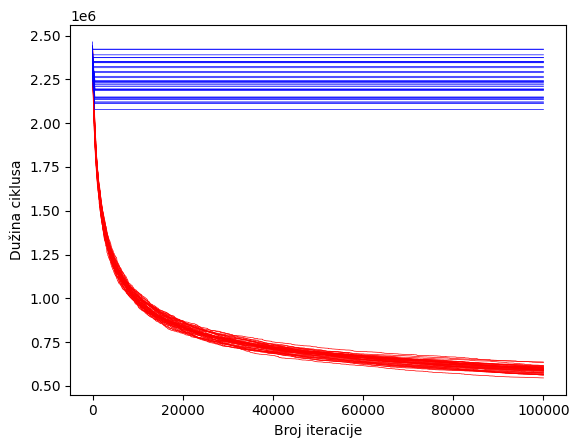

In [15]:
fig, ax = plt.subplots()
for T in np.linspace(1, 200000, 40):
    fastZimbabwe = SimulatedAnnealing(zimbabwe)
    start = timeit.default_timer()
    fastZimbabweRes = fastZimbabwe.optimize(num_iters=100000, T0=T, fast_annealing=True, end_fitness=0)
    stop = timeit.default_timer()
    print(f'============T={T}==========================')
    print(f'Best cycle:{fastZimbabwe.cycle}\nBest fitness:{fastZimbabwe.fitness}\nTime:{stop-start}')
    ax.plot(range(len(fastZimbabweRes)), fastZimbabweRes, color = 'red', lw=0.5)
    
for trs in (0.0001, 0.01, 0.1, 0.9):
    for tas in (10, 100, 1000):
        for rr in (10, 30, 50):
            
            adaptiveZimbabwe = AdaptiveSimulatedAnnealing(zimbabwe)
            adaptiveZimbabwe.reannealingRate = rr
            adaptiveZimbabwe.temperature_ratio_scale = trs
            adaptiveZimbabwe.temperature_anneal_scale = tas
            adaptiveZimbabwe.calculatec()
            adaptiveZimbabwe.maxIters = 100000
            start = timeit.default_timer()
            adaptiveZimbabweRes = adaptiveZimbabwe.optimize(end_fitness=0)
            stop = timeit.default_timer()
            print(f'=======trs {trs}===tas {tas}=====rr {rr}================')
            print(f'Best cycle:{adaptiveZimbabwe.cycle}\nBest fitness:{adaptiveZimbabwe.fitness}\nTime:{stop-start}')
            ax.plot(range(len(adaptiveZimbabweRes)), adaptiveZimbabweRes, color = 'blue', lw=0.5)

ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')

plt.show()

In [381]:
fastBerlinRes[10000]

9464.072408887358

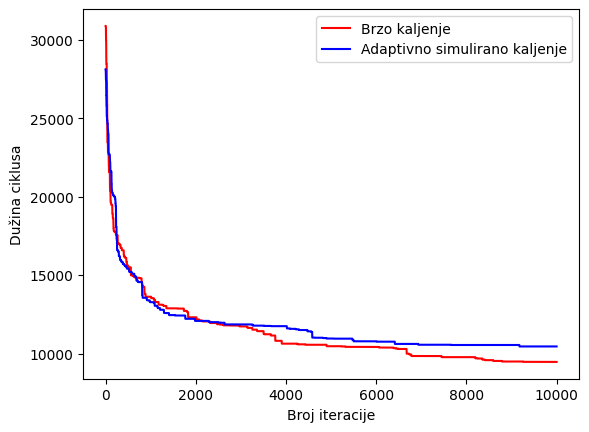

In [378]:
fig, ax = plt.subplots()
ax.plot(range(len(fastBerlinRes[])), fastBerlinRes[], color = 'red', label='Brzo kaljenje')
ax.plot(range(len(adaptiveBerlinRes[])), adaptiveBerlinRes[], color = 'blue', label='Adaptivno simulirano kaljenje')
ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')
plt.legend()
plt.show()

In [ ]:
edgeList = []
for i in range(len(t)-1):
    edgeList.append((t[i], t[i+1]))
edgeList.append((t[0], t[-1]))
pos = {}
labels = {}
for u in rs.nodes:
    x = rs.nodes[u]['x'] /1000000000
    y = rs.nodes[u]['y'] /1000000
    pos[u] = (x,y)
    labels[u] = rs.nodes[u]['name']
print(pos)
nx.draw(rs, edgelist = edgeList, pos=pos, labels = labels, with_labels = True, node_size=100, width=5 )

In [ ]:
t = nx.algorithms.approximation.simulated_annealing_tsp(rs, "greedy", max_iterations = 10000)

In [ ]:
cost = sum(rs[n][nbr]["weight"] for n, nbr in nx.utils.pairwise(t))

In [ ]:
cost

In [ ]:
t

In [ ]:
g = load_data('dj38.tsp')

In [ ]:
a0 = SimulatedAnnealing(g)

In [ ]:
a0.optimize(1000000, 10000, True)

In [ ]:
a = AdaptiveSimulatedAnnealing(g)
a.maxIters = 1000000
a.reannealingRate = 10

#Inberg defalut values
a.temperature_ratio_scale = 0.00001
a.temperature_anneal_scale = 100.0

#tested values
#a.temperature_ratio_scale = 0.5
#a.temperature_anneal_scale = 500

a.calculatec()
a.optimize()

In [ ]:
a.Tcost


In [ ]:

draw(g,a, False)

In [ ]:
a.fitness

============T=1.0==========================
Best cycle:[39, 4, 14, 5, 3, 27, 26, 12, 25, 49, 19, 22, 29, 1, 6, 41, 20, 30, 0, 33, 43, 15, 28, 46, 13, 51, 10, 11, 24, 45, 47, 23, 37, 36, 34, 48, 31, 44, 8, 9, 32, 50, 42, 7, 40, 18, 2, 16, 17, 21, 35, 38]
Best fitness:10288.466103740386
Time:7.887700926978141
============T=411.2307692307692==========================
Best cycle:[38, 44, 9, 8, 7, 40, 18, 42, 32, 11, 27, 26, 25, 46, 1, 6, 41, 22, 36, 39, 37, 14, 4, 23, 47, 5, 3, 50, 10, 51, 13, 12, 24, 45, 33, 34, 43, 49, 19, 29, 28, 15, 0, 21, 30, 20, 16, 2, 17, 31, 48, 35]
Best fitness:10343.856087203108
Time:8.121338072000071
============T=821.4615384615385==========================
Best cycle:[3, 23, 47, 37, 39, 38, 48, 21, 30, 22, 29, 43, 33, 34, 35, 0, 19, 49, 15, 36, 4, 14, 5, 24, 45, 28, 46, 25, 27, 11, 32, 9, 8, 7, 40, 18, 31, 17, 20, 41, 1, 6, 16, 2, 44, 42, 26, 12, 13, 51, 10, 50]
Best fitness:10306.75997951859
Time:7.993886334996205
============T=1231.6923076923076==============

============T=10667.0==========================
Best cycle:[43, 49, 19, 28, 15, 45, 5, 3, 50, 10, 51, 13, 12, 46, 41, 1, 6, 16, 30, 21, 48, 34, 33, 35, 38, 39, 37, 23, 47, 24, 25, 26, 27, 11, 32, 9, 8, 40, 2, 17, 20, 29, 22, 0, 31, 44, 18, 7, 42, 14, 4, 36]
Best fitness:10327.902988836351
Time:7.502190572966356
============T=11077.23076923077==========================
Best cycle:[18, 40, 16, 6, 1, 41, 29, 20, 21, 0, 43, 33, 34, 35, 38, 44, 7, 8, 9, 32, 50, 10, 11, 42, 48, 31, 2, 17, 30, 22, 19, 25, 12, 51, 13, 46, 28, 49, 15, 45, 26, 27, 24, 47, 23, 4, 5, 3, 14, 37, 36, 39]
Best fitness:11009.721857611024
Time:7.825824505009223
============T=11487.461538461539==========================
Best cycle:[11, 27, 26, 10, 50, 32, 9, 8, 40, 2, 16, 17, 30, 21, 48, 35, 34, 0, 19, 49, 28, 15, 45, 24, 42, 7, 18, 44, 31, 38, 39, 37, 4, 14, 3, 5, 23, 47, 36, 33, 43, 25, 12, 51, 13, 46, 29, 1, 6, 41, 20, 22]
Best fitness:10638.776745181838
Time:7.744808992021717
============T=11897.692307692307========

=======trs 0.0001===tas 100=====rr 10================
Best cycle:[36, 38, 35, 34, 33, 43, 0, 48, 31, 2, 16, 6, 1, 41, 29, 28, 27, 26, 12, 13, 46, 25, 24, 42, 32, 9, 8, 7, 40, 18, 44, 39, 5, 3, 50, 10, 51, 11, 21, 17, 30, 20, 22, 19, 49, 15, 45, 47, 23, 4, 14, 37]
Best fitness:10033.62037003275
Time:8.86325905501144
=======trs 0.0001===tas 100=====rr 30================
Best cycle:[44, 35, 0, 21, 30, 22, 19, 43, 45, 47, 37, 39, 38, 34, 33, 36, 23, 24, 11, 10, 51, 13, 12, 46, 28, 49, 15, 25, 26, 27, 5, 4, 14, 3, 50, 32, 42, 9, 8, 7, 40, 31, 48, 17, 20, 29, 1, 6, 41, 16, 2, 18]
Best fitness:10078.540337911463
Time:8.758315808954649
=======trs 0.0001===tas 100=====rr 50================
Best cycle:[10, 51, 13, 12, 47, 44, 18, 40, 7, 8, 9, 42, 14, 4, 37, 39, 38, 35, 48, 0, 34, 33, 43, 45, 15, 49, 28, 46, 25, 26, 27, 11, 24, 3, 5, 23, 36, 21, 17, 2, 16, 41, 6, 1, 29, 19, 22, 20, 30, 31, 32, 50]
Best fitness:9885.384363841424
Time:8.786267767020036
=======trs 0.0001===tas 1000=====rr 10========

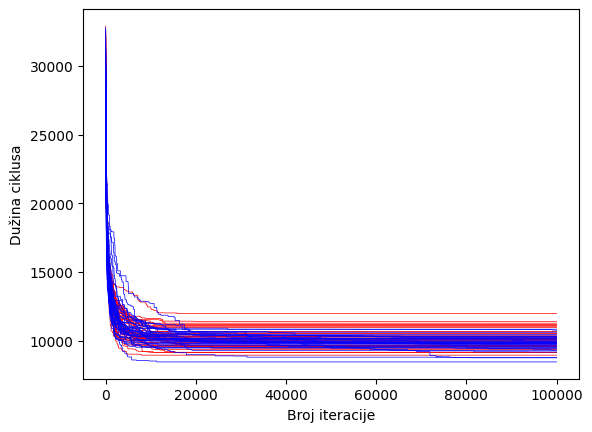

In [18]:
fig, ax = plt.subplots()
for T in np.linspace(1, 16000, 40):
    fastBerlin = SimulatedAnnealing(berlin)
    start = timeit.default_timer()
    fastBerlinRes = fastBerlin.optimize(num_iters=100000, T0=T, fast_annealing=True, end_fitness=0)
    stop = timeit.default_timer()
    print(f'============T={T}==========================')
    print(f'Best cycle:{fastBerlin.cycle}\nBest fitness:{fastBerlin.fitness}\nTime:{stop-start}')
    ax.plot(range(len(fastBerlinRes)), fastBerlinRes, color = 'red', lw=0.5)
    
for trs in (0.00001, 0.0001, 0.001, 0.01):
    for tas in (10, 100, 1000):
        for rr in (10, 30, 50):
            
            adaptiveBerlin = AdaptiveSimulatedAnnealing(berlin)
            adaptiveBerlin.reannealingRate = rr
            adaptiveBerlin.temperature_ratio_scale = trs
            adaptiveBerlin.temperature_anneal_scale = tas
            adaptiveBerlin.calculatec()
            adaptiveBerlin.maxIters = 100000
            start = timeit.default_timer()
            adaptiveBerlinRes = adaptiveBerlin.optimize(end_fitness=0)
            stop = timeit.default_timer()
            print(f'=======trs {trs}===tas {tas}=====rr {rr}================')
            print(f'Best cycle:{adaptiveBerlin.cycle}\nBest fitness:{adaptiveBerlin.fitness}\nTime:{stop-start}')
            ax.plot(range(len(adaptiveBerlinRes)), adaptiveBerlinRes, color = 'blue', lw=0.5)

ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')

plt.show()

============T=1.0==========================
Best cycle:[2, 1, 20, 32, 92, 150, 161, 170, 165, 159, 142, 80, 69, 59, 68, 73, 90, 117, 130, 120, 119, 54, 48, 53, 52, 51, 41, 49, 18, 14, 4, 11, 29, 31, 30, 34, 43, 37, 40, 42, 45, 47, 55, 57, 56, 71, 74, 75, 70, 61, 58, 16, 27, 28, 36, 50, 65, 96, 105, 167, 183, 182, 186, 185, 181, 193, 189, 191, 180, 176, 177, 179, 169, 166, 26, 9, 8, 21, 17, 6, 3, 5, 0, 19, 64, 62, 110, 129, 155, 188, 190, 187, 192, 184, 147, 134, 128, 95, 94, 91, 87, 82, 78, 76, 83, 99, 122, 123, 127, 132, 135, 146, 140, 121, 101, 15, 7, 35, 88, 98, 93, 97, 85, 84, 89, 81, 79, 77, 38, 33, 39, 46, 60, 66, 72, 109, 111, 108, 112, 100, 103, 126, 131, 137, 138, 153, 141, 139, 125, 113, 86, 25, 23, 24, 22, 12, 10, 13, 143, 151, 152, 156, 149, 136, 118, 102, 104, 106, 107, 124, 133, 144, 163, 172, 173, 178, 175, 160, 145, 148, 162, 168, 171, 174, 164, 158, 157, 154, 116, 115, 114, 67, 63, 44]
Best fitness:20918.700770454307
Time:30.53256067202892
============T=513.79487179487

============T=4616.153846153847==========================
Best cycle:[5, 2, 4, 8, 21, 27, 32, 89, 97, 129, 133, 131, 126, 110, 103, 93, 85, 84, 62, 61, 70, 56, 50, 46, 51, 45, 40, 47, 52, 57, 55, 53, 43, 34, 30, 31, 29, 18, 14, 26, 28, 71, 88, 98, 100, 124, 125, 143, 151, 152, 149, 153, 138, 137, 121, 130, 135, 154, 157, 161, 169, 179, 192, 187, 190, 191, 188, 180, 177, 134, 128, 159, 156, 172, 173, 182, 174, 150, 147, 142, 132, 120, 116, 94, 68, 59, 69, 91, 96, 158, 166, 164, 118, 22, 12, 10, 25, 23, 109, 111, 114, 119, 170, 184, 165, 101, 6, 3, 1, 0, 19, 64, 113, 146, 167, 176, 183, 186, 189, 193, 185, 178, 87, 78, 83, 99, 115, 171, 181, 175, 168, 155, 144, 148, 160, 162, 163, 117, 95, 92, 73, 77, 74, 24, 13, 16, 17, 33, 37, 48, 54, 127, 123, 122, 49, 41, 11, 9, 44, 63, 82, 80, 67, 76, 72, 65, 66, 60, 42, 39, 38, 36, 20, 15, 35, 58, 81, 86, 90, 104, 106, 107, 105, 102, 112, 136, 139, 141, 145, 140, 108, 79, 75, 7]
Best fitness:22146.422439909195
Time:30.3630170559627
============T=51

============T=9231.307692307693==========================
Best cycle:[179, 177, 192, 184, 170, 165, 159, 132, 111, 76, 56, 32, 23, 24, 22, 13, 12, 16, 20, 36, 33, 30, 29, 18, 14, 9, 8, 26, 38, 99, 109, 150, 157, 158, 161, 154, 147, 142, 134, 128, 114, 83, 80, 78, 55, 51, 52, 57, 82, 87, 108, 125, 124, 141, 144, 139, 133, 103, 100, 61, 15, 7, 5, 3, 6, 10, 71, 77, 112, 113, 145, 149, 153, 156, 151, 140, 54, 48, 49, 41, 43, 53, 60, 65, 66, 44, 59, 68, 90, 101, 102, 105, 104, 106, 107, 96, 91, 94, 92, 95, 130, 135, 146, 152, 164, 176, 180, 187, 188, 190, 191, 189, 183, 166, 127, 123, 122, 119, 120, 116, 115, 117, 118, 97, 84, 64, 85, 129, 155, 175, 181, 193, 186, 185, 182, 172, 173, 110, 98, 89, 58, 35, 25, 17, 21, 28, 27, 73, 74, 75, 86, 79, 70, 81, 88, 93, 131, 136, 137, 138, 143, 121, 72, 47, 45, 40, 42, 39, 46, 50, 67, 69, 63, 37, 34, 31, 11, 4, 2, 1, 0, 19, 62, 126, 148, 160, 162, 163, 168, 171, 178, 174, 167, 169]
Best fitness:18433.868201338795
Time:30.73888372402871
============T=9

============T=13846.461538461539==========================
Best cycle:[139, 144, 148, 160, 162, 163, 151, 146, 150, 116, 114, 115, 117, 143, 153, 156, 152, 149, 140, 102, 90, 86, 79, 61, 88, 98, 100, 81, 70, 75, 50, 46, 53, 48, 54, 122, 123, 127, 132, 128, 135, 130, 121, 97, 85, 84, 93, 103, 112, 108, 105, 104, 120, 134, 165, 184, 179, 192, 190, 188, 186, 185, 171, 168, 138, 95, 57, 55, 52, 51, 72, 109, 111, 147, 154, 161, 159, 142, 119, 106, 107, 66, 60, 42, 37, 30, 34, 49, 99, 180, 187, 183, 83, 65, 26, 21, 28, 63, 69, 172, 173, 178, 181, 175, 155, 35, 5, 7, 15, 12, 16, 25, 68, 73, 82, 87, 92, 118, 137, 145, 141, 133, 131, 110, 89, 64, 19, 0, 2, 4, 14, 18, 11, 9, 8, 182, 193, 189, 191, 177, 169, 170, 166, 157, 158, 167, 176, 174, 164, 77, 74, 71, 23, 20, 17, 32, 27, 44, 67, 76, 94, 96, 91, 80, 78, 24, 22, 13, 10, 6, 1, 3, 113, 124, 126, 129, 62, 58, 31, 29, 41, 43, 45, 47, 40, 39, 33, 38, 36, 56, 59, 101, 125, 136]
Best fitness:22966.30133788142
Time:30.69774974999018
============T=1

============T=18461.615384615387==========================
Best cycle:[179, 177, 180, 167, 157, 150, 130, 105, 96, 91, 53, 48, 41, 37, 39, 23, 25, 71, 77, 101, 118, 145, 173, 172, 174, 164, 158, 152, 156, 153, 149, 138, 137, 100, 98, 93, 97, 85, 84, 64, 89, 88, 81, 75, 74, 73, 68, 56, 44, 36, 38, 50, 67, 132, 142, 147, 159, 184, 192, 190, 188, 186, 182, 183, 176, 166, 135, 54, 49, 29, 9, 8, 10, 6, 3, 0, 19, 62, 35, 58, 61, 12, 22, 70, 155, 160, 148, 144, 113, 86, 79, 108, 162, 168, 175, 181, 178, 171, 163, 129, 110, 103, 125, 124, 126, 131, 133, 139, 141, 136, 112, 90, 17, 4, 2, 1, 5, 7, 15, 143, 151, 140, 121, 102, 92, 80, 76, 63, 69, 94, 185, 193, 189, 191, 187, 95, 87, 59, 32, 27, 28, 21, 26, 33, 30, 31, 34, 43, 51, 52, 66, 83, 117, 146, 161, 170, 165, 154, 134, 128, 120, 18, 14, 11, 16, 13, 24, 20, 46, 42, 57, 99, 109, 111, 115, 116, 114, 107, 106, 72, 55, 47, 40, 45, 60, 65, 78, 82, 104, 119, 122, 123, 127, 169]
Best fitness:21178.938069140193
Time:31.374449183989782
============T

=======trs 1e-05===tas 100=====rr 50================
Best cycle:[94, 96, 91, 80, 72, 45, 40, 37, 4, 2, 1, 0, 3, 68, 73, 120, 132, 142, 147, 157, 167, 180, 183, 182, 186, 189, 191, 190, 188, 187, 192, 184, 154, 111, 109, 52, 55, 57, 65, 83, 99, 107, 106, 104, 70, 61, 108, 112, 140, 151, 146, 115, 114, 92, 90, 86, 74, 59, 56, 26, 11, 9, 8, 6, 7, 5, 19, 97, 155, 181, 193, 185, 178, 145, 100, 98, 93, 89, 88, 81, 46, 42, 47, 51, 53, 122, 123, 127, 159, 165, 170, 169, 179, 177, 176, 174, 172, 173, 156, 44, 36, 33, 38, 67, 76, 105, 150, 158, 161, 166, 164, 152, 149, 153, 163, 168, 175, 171, 143, 121, 102, 95, 82, 78, 69, 63, 16, 13, 22, 24, 71, 25, 23, 20, 17, 39, 41, 34, 30, 31, 14, 18, 29, 49, 54, 48, 43, 21, 10, 12, 15, 35, 64, 85, 84, 62, 58, 117, 116, 130, 135, 134, 128, 119, 66, 60, 50, 28, 27, 32, 101, 118, 138, 137, 136, 133, 129, 110, 103, 126, 131, 139, 144, 162, 160, 148, 141, 125, 124, 113, 79, 75, 77, 87]
Best fitness:20390.1447753255
Time:31.34876352502033
=======trs 1e-05===tas

=======trs 0.0001===tas 100=====rr 50================
Best cycle:[51, 52, 47, 41, 43, 45, 40, 37, 34, 30, 26, 27, 32, 16, 13, 12, 10, 6, 21, 28, 44, 122, 123, 159, 165, 169, 179, 177, 176, 167, 164, 152, 118, 112, 108, 75, 25, 23, 20, 17, 59, 87, 92, 95, 105, 116, 120, 128, 134, 127, 66, 65, 50, 38, 33, 39, 42, 46, 60, 83, 106, 130, 170, 184, 192, 191, 189, 186, 182, 172, 163, 144, 139, 146, 150, 147, 142, 154, 180, 187, 190, 188, 183, 174, 151, 140, 117, 107, 82, 67, 57, 55, 53, 54, 48, 49, 31, 29, 18, 14, 36, 56, 73, 77, 74, 143, 149, 153, 156, 173, 168, 162, 160, 148, 145, 141, 136, 133, 97, 64, 19, 15, 7, 5, 0, 1, 3, 71, 90, 102, 101, 113, 125, 124, 103, 110, 126, 131, 171, 178, 185, 193, 181, 175, 155, 129, 85, 84, 89, 93, 98, 137, 138, 121, 94, 91, 80, 78, 69, 68, 24, 22, 61, 70, 79, 86, 104, 63, 76, 11, 9, 8, 4, 2, 58, 35, 62, 88, 100, 81, 96, 99, 109, 111, 114, 115, 135, 157, 158, 166, 161, 132, 119, 72]
Best fitness:19457.507757350562
Time:32.74550991400611
=======trs 0.0001==

=======trs 0.001===tas 100=====rr 50================
Best cycle:[121, 96, 91, 82, 78, 80, 94, 104, 130, 135, 134, 128, 120, 117, 102, 61, 35, 77, 92, 87, 73, 68, 32, 28, 21, 46, 50, 60, 67, 69, 95, 105, 118, 112, 108, 86, 22, 24, 10, 2, 4, 8, 11, 31, 149, 163, 178, 173, 172, 174, 183, 180, 156, 113, 103, 98, 100, 64, 19, 0, 1, 3, 6, 9, 26, 37, 45, 48, 49, 41, 55, 47, 38, 17, 20, 15, 5, 7, 12, 27, 36, 33, 30, 40, 51, 43, 42, 39, 44, 116, 119, 127, 123, 122, 109, 90, 75, 70, 58, 62, 85, 84, 97, 110, 129, 155, 175, 181, 171, 153, 101, 71, 23, 25, 16, 13, 74, 140, 176, 187, 188, 190, 191, 189, 193, 160, 145, 125, 124, 139, 141, 182, 192, 184, 170, 159, 165, 161, 150, 154, 147, 142, 132, 114, 99, 76, 63, 56, 59, 79, 81, 88, 89, 93, 126, 131, 133, 136, 144, 148, 162, 168, 185, 186, 152, 151, 146, 107, 106, 83, 65, 66, 57, 53, 54, 34, 29, 18, 14, 52, 72, 111, 115, 157, 158, 169, 179, 177, 167, 166, 164, 143, 138, 137]
Best fitness:20249.578863793115
Time:33.37967077200301
=======trs 0.001===t

=======trs 0.01===tas 100=====rr 50================
Best cycle:[79, 68, 92, 86, 17, 11, 18, 14, 7, 15, 66, 51, 37, 49, 60, 115, 142, 147, 135, 121, 125, 133, 129, 85, 64, 19, 124, 178, 172, 173, 176, 186, 190, 188, 183, 184, 165, 169, 185, 171, 148, 144, 168, 163, 162, 131, 105, 87, 99, 134, 179, 189, 181, 167, 146, 90, 23, 24, 100, 126, 160, 191, 192, 187, 182, 157, 161, 152, 159, 150, 154, 98, 103, 141, 193, 175, 174, 164, 143, 153, 140, 94, 76, 21, 8, 33, 39, 73, 149, 166, 158, 136, 88, 84, 97, 101, 156, 138, 151, 119, 116, 59, 6, 1, 3, 0, 5, 32, 69, 31, 20, 13, 10, 12, 70, 58, 75, 25, 42, 40, 54, 47, 45, 80, 81, 35, 61, 139, 145, 155, 102, 91, 108, 112, 82, 83, 78, 104, 120, 130, 106, 2, 4, 9, 36, 50, 26, 52, 170, 180, 177, 113, 62, 16, 71, 65, 55, 57, 28, 44, 63, 56, 109, 111, 41, 43, 53, 34, 29, 107, 122, 114, 74, 22, 110, 137, 128, 72, 38, 123, 127, 132, 27, 77, 93, 89, 118, 117, 48, 30, 46, 67, 96, 95]
Best fitness:35183.0754726941
Time:30.182378974044695
=======trs 0.01===tas 

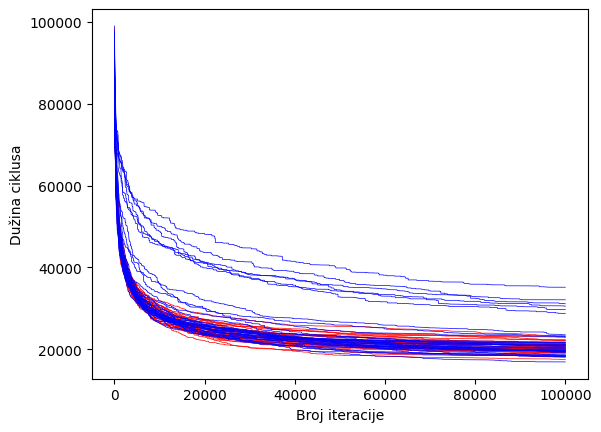

In [19]:
fig, ax = plt.subplots()
for T in np.linspace(1, 20000, 40):
    fastQatar = SimulatedAnnealing(qa)
    start = timeit.default_timer()
    fastQatarRes = fastQatar.optimize(num_iters=100000, T0=T, fast_annealing=True, end_fitness=0)
    stop = timeit.default_timer()
    print(f'============T={T}==========================')
    print(f'Best cycle:{fastQatar.cycle}\nBest fitness:{fastQatar.fitness}\nTime:{stop-start}')
    ax.plot(range(len(fastQatarRes)), fastQatarRes, color = 'red', lw=0.5)
    
for trs in (0.00001, 0.0001, 0.001, 0.01):
    for tas in (10, 100, 1000):
        for rr in (10, 30, 50):
            
            adaptiveQatar = AdaptiveSimulatedAnnealing(qa)
            adaptiveQatar.reannealingRate = rr
            adaptiveQatar.temperature_ratio_scale = trs
            adaptiveQatar.temperature_anneal_scale = tas
            adaptiveQatar.calculatec()
            adaptiveQatar.maxIters = 100000
            start = timeit.default_timer()
            adaptiveQatarRes = adaptiveQatar.optimize(end_fitness=0)
            stop = timeit.default_timer()
            print(f'=======trs {trs}===tas {tas}=====rr {rr}================')
            print(f'Best cycle:{adaptiveQatar.cycle}\nBest fitness:{adaptiveQatar.fitness}\nTime:{stop-start}')
            ax.plot(range(len(adaptiveQatarRes)), adaptiveQatarRes, color = 'blue', lw=0.5)

ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')

plt.show()

KeyboardInterrupt: 

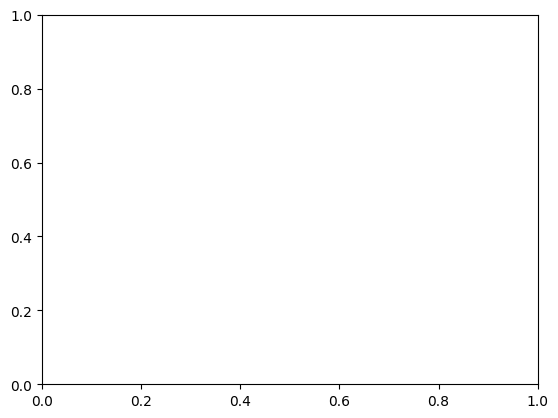

In [20]:
fig, ax = plt.subplots()
for T in np.linspace(1, 200000, 40):
    fastZimbabwe = SimulatedAnnealing(zimbabwe)
    start = timeit.default_timer()
    fastZimbabweRes = fastZimbabwe.optimize(num_iters=100000, T0=T, fast_annealing=True, end_fitness=0)
    stop = timeit.default_timer()
    print(f'============T={T}==========================')
    print(f'Best cycle:{fastZimbabwe.cycle}\nBest fitness:{fastZimbabwe.fitness}\nTime:{stop-start}')
    ax.plot(range(len(fastZimbabweRes)), fastZimbabweRes, color = 'red', lw=0.5)
    
for trs in (0.00001, 0.0001, 0.001, 0.01):
    for tas in (10, 100, 1000):
        for rr in (10, 30, 50):
            
            adaptiveZimbabwe = AdaptiveSimulatedAnnealing(zimbabwe)
            adaptiveZimbabwe.reannealingRate = rr
            adaptiveZimbabwe.temperature_ratio_scale = trs
            adaptiveZimbabwe.temperature_anneal_scale = tas
            adaptiveZimbabwe.calculatec()
            adaptiveZimbabwe.maxIters = 100000
            start = timeit.default_timer()
            adaptiveZimbabweRes = adaptiveZimbabwe.optimize(end_fitness=0)
            stop = timeit.default_timer()
            print(f'=======trs {trs}===tas {tas}=====rr {rr}================')
            print(f'Best cycle:{adaptiveZimbabwe.cycle}\nBest fitness:{adaptiveZimbabwe.fitness}\nTime:{stop-start}')
            ax.plot(range(len(adaptiveZimbabweRes)), adaptiveZimbabweRes, color = 'blue', lw=0.5)

ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')

plt.show()

============T=1.0==========================
Best cycle:[28, 29, 30, 17, 21, 48, 31, 44, 2, 16, 41, 20, 22, 15, 45, 11, 50, 10, 32, 42, 14, 4, 37, 23, 5, 3, 24, 26, 51, 13, 12, 46, 25, 27, 47, 36, 39, 33, 43, 1, 6, 34, 35, 38, 9, 8, 7, 40, 18, 0, 19, 49]
Best fitness:11391.065210103656
Time:0.7805022450047545
============T=411.2307692307692==========================
Best cycle:[45, 27, 26, 25, 46, 28, 29, 30, 22, 19, 49, 15, 43, 0, 2, 40, 7, 8, 9, 18, 44, 37, 4, 14, 5, 23, 47, 36, 48, 31, 21, 17, 16, 20, 41, 6, 1, 33, 34, 35, 38, 39, 42, 32, 50, 10, 51, 13, 12, 11, 3, 24]
Best fitness:10044.184061093518
Time:0.8037560390075669
============T=821.4615384615385==========================
Best cycle:[29, 20, 16, 41, 6, 1, 28, 15, 43, 36, 37, 39, 44, 18, 40, 7, 8, 9, 14, 23, 47, 38, 35, 34, 33, 0, 17, 2, 31, 48, 4, 5, 27, 26, 51, 13, 12, 46, 25, 24, 3, 42, 32, 50, 10, 11, 45, 49, 19, 21, 30, 22]
Best fitness:10382.716886785043
Time:0.8151752050034702
============T=1231.6923076923076==========

============T=10667.0==========================
Best cycle:[16, 2, 18, 44, 24, 27, 10, 51, 13, 12, 26, 25, 46, 28, 15, 45, 47, 23, 4, 5, 3, 14, 37, 36, 33, 43, 29, 41, 1, 6, 40, 7, 8, 9, 42, 32, 50, 11, 39, 38, 35, 34, 0, 21, 30, 22, 19, 49, 48, 31, 17, 20]
Best fitness:10089.811536650695
Time:0.787235518975649
============T=11077.23076923077==========================
Best cycle:[15, 49, 19, 29, 22, 30, 16, 2, 18, 44, 17, 21, 0, 43, 20, 41, 6, 1, 28, 46, 25, 24, 5, 14, 4, 37, 36, 39, 38, 33, 34, 35, 48, 31, 40, 7, 8, 9, 42, 3, 32, 50, 10, 51, 13, 12, 26, 27, 11, 23, 47, 45]
Best fitness:9745.382325775932
Time:0.7801710120402277
============T=11487.461538461539==========================
Best cycle:[32, 30, 17, 2, 40, 7, 18, 34, 33, 36, 43, 45, 47, 23, 4, 14, 5, 3, 42, 44, 31, 21, 0, 48, 35, 38, 39, 37, 24, 27, 26, 25, 46, 13, 12, 51, 10, 9, 8, 16, 20, 41, 6, 1, 29, 22, 19, 49, 28, 15, 11, 50]
Best fitness:10721.09545997131
Time:0.8041055439971387
============T=11897.692307692307========

=======trs 0.0001===tas 100=====rr 10================
Best cycle:[35, 38, 9, 8, 7, 40, 31, 48, 0, 49, 19, 22, 20, 30, 17, 2, 18, 44, 39, 37, 47, 23, 4, 14, 5, 3, 24, 45, 27, 11, 10, 50, 32, 42, 36, 43, 15, 46, 25, 26, 12, 51, 13, 28, 29, 1, 6, 41, 16, 21, 33, 34]
Best fitness:10305.63049226233
Time:0.8811651659780182
=======trs 0.0001===tas 100=====rr 30================
Best cycle:[7, 8, 9, 42, 32, 10, 51, 13, 12, 46, 28, 49, 19, 22, 29, 41, 1, 6, 16, 20, 30, 24, 50, 11, 27, 26, 25, 45, 47, 23, 36, 38, 35, 33, 43, 15, 34, 48, 0, 21, 31, 39, 37, 4, 5, 3, 14, 44, 17, 2, 18, 40]
Best fitness:9838.249879130388
Time:0.8825122559792362
=======trs 0.0001===tas 100=====rr 50================
Best cycle:[15, 49, 19, 43, 47, 23, 37, 36, 28, 29, 1, 6, 41, 22, 33, 34, 35, 48, 0, 21, 17, 31, 39, 38, 30, 20, 16, 2, 18, 40, 7, 8, 9, 44, 4, 5, 24, 27, 26, 11, 32, 42, 14, 3, 50, 10, 51, 12, 13, 46, 25, 45]
Best fitness:10392.494410565843
Time:0.8595147649757564
=======trs 0.0001===tas 1000=====rr 10====

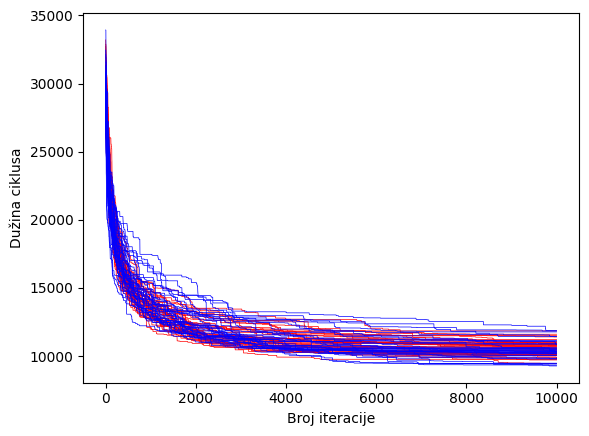

In [23]:
fig, ax = plt.subplots()
for T in np.linspace(1, 16000, 40):
    fastBerlin = SimulatedAnnealing(berlin)
    start = timeit.default_timer()
    fastBerlinRes = fastBerlin.optimize(num_iters=10000, T0=T, fast_annealing=True, end_fitness=0)
    stop = timeit.default_timer()
    print(f'============T={T}==========================')
    print(f'Best cycle:{fastBerlin.cycle}\nBest fitness:{fastBerlin.fitness}\nTime:{stop-start}')
    ax.plot(range(len(fastBerlinRes)), fastBerlinRes, color = 'red', lw=0.5)
    
for trs in (0.00001, 0.0001, 0.001, 0.01):
    for tas in (10, 100, 1000):
        for rr in (10, 30, 50):
            
            adaptiveBerlin = AdaptiveSimulatedAnnealing(berlin)
            adaptiveBerlin.reannealingRate = rr
            adaptiveBerlin.temperature_ratio_scale = trs
            adaptiveBerlin.temperature_anneal_scale = tas
            adaptiveBerlin.calculatec()
            adaptiveBerlin.maxIters = 10000
            start = timeit.default_timer()
            adaptiveBerlinRes = adaptiveBerlin.optimize(end_fitness=0)
            stop = timeit.default_timer()
            print(f'=======trs {trs}===tas {tas}=====rr {rr}================')
            print(f'Best cycle:{adaptiveBerlin.cycle}\nBest fitness:{adaptiveBerlin.fitness}\nTime:{stop-start}')
            ax.plot(range(len(adaptiveBerlinRes)), adaptiveBerlinRes, color = 'blue', lw=0.5)

ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')

plt.show()

============T=1.0==========================
Best cycle:[116, 120, 127, 123, 122, 99, 76, 32, 20, 17, 28, 36, 95, 156, 152, 111, 109, 128, 166, 169, 164, 130, 86, 79, 133, 139, 141, 144, 175, 181, 185, 193, 189, 190, 191, 186, 173, 126, 24, 10, 13, 98, 100, 145, 148, 92, 55, 42, 40, 53, 57, 50, 59, 22, 7, 5, 0, 93, 89, 88, 81, 108, 143, 158, 157, 161, 147, 135, 106, 63, 56, 68, 71, 77, 162, 163, 183, 188, 187, 167, 179, 150, 154, 112, 103, 97, 62, 6, 16, 3, 23, 140, 117, 69, 60, 46, 72, 132, 142, 165, 170, 184, 177, 182, 172, 153, 149, 29, 14, 11, 45, 47, 66, 65, 83, 114, 115, 107, 96, 105, 101, 124, 125, 131, 136, 82, 78, 43, 41, 18, 4, 8, 9, 37, 39, 44, 27, 2, 1, 25, 21, 31, 30, 34, 67, 134, 146, 151, 176, 180, 178, 137, 138, 121, 91, 26, 33, 49, 48, 54, 51, 52, 38, 61, 35, 19, 64, 58, 15, 12, 73, 94, 102, 118, 113, 75, 90, 87, 80, 74, 70, 110, 155, 168, 171, 160, 129, 85, 84, 174, 192, 159, 119, 104]
Best fitness:29602.930350564235
Time:3.0153100850293413
============T=513.7948717948

============T=4616.153846153847==========================
Best cycle:[111, 115, 130, 174, 168, 175, 129, 85, 84, 62, 63, 60, 45, 40, 57, 55, 20, 23, 2, 7, 10, 22, 24, 61, 133, 143, 48, 41, 67, 76, 102, 146, 164, 184, 185, 32, 17, 27, 83, 165, 192, 176, 180, 183, 188, 182, 19, 64, 97, 110, 124, 144, 155, 131, 118, 95, 69, 65, 72, 191, 189, 186, 193, 178, 181, 103, 93, 8, 9, 26, 107, 150, 161, 169, 170, 166, 158, 157, 79, 70, 71, 56, 73, 122, 123, 117, 101, 86, 90, 82, 80, 44, 36, 14, 11, 18, 43, 54, 87, 141, 148, 145, 105, 42, 37, 33, 59, 25, 12, 13, 0, 1, 4, 21, 39, 51, 30, 6, 3, 5, 35, 75, 78, 38, 49, 29, 31, 34, 46, 50, 53, 66, 52, 47, 28, 68, 88, 89, 160, 171, 162, 163, 125, 112, 108, 121, 167, 179, 177, 187, 190, 98, 58, 15, 16, 74, 77, 104, 106, 120, 132, 137, 136, 139, 138, 135, 134, 147, 142, 128, 116, 91, 94, 92, 96, 99, 109, 114, 140, 173, 172, 126, 100, 81, 113, 149, 152, 156, 153, 151, 154, 159, 127, 119]
Best fitness:31358.535592718246
Time:2.968654155964032
============T=5

============T=9231.307692307693==========================
Best cycle:[0, 19, 97, 131, 133, 152, 157, 158, 154, 123, 122, 78, 6, 10, 8, 33, 41, 39, 34, 51, 42, 50, 40, 37, 44, 27, 64, 62, 12, 23, 60, 72, 63, 87, 82, 68, 79, 75, 71, 90, 94, 77, 86, 103, 85, 84, 16, 56, 111, 120, 127, 135, 150, 170, 184, 180, 174, 172, 161, 119, 99, 55, 47, 57, 76, 73, 98, 89, 126, 124, 144, 141, 137, 149, 146, 142, 147, 164, 175, 181, 173, 148, 155, 145, 138, 136, 139, 113, 125, 100, 7, 5, 2, 1, 17, 20, 21, 107, 114, 159, 165, 166, 167, 169, 132, 54, 48, 36, 38, 46, 9, 4, 26, 121, 143, 162, 171, 156, 151, 130, 80, 67, 83, 95, 92, 91, 65, 45, 52, 49, 43, 53, 102, 101, 108, 112, 74, 25, 28, 30, 29, 31, 24, 61, 88, 110, 129, 163, 140, 118, 81, 35, 93, 58, 15, 13, 22, 70, 117, 153, 182, 189, 186, 185, 168, 160, 178, 193, 187, 191, 188, 190, 115, 104, 69, 32, 59, 128, 179, 177, 192, 183, 176, 134, 116, 109, 106, 96, 105, 66, 14, 18, 11, 3]
Best fitness:28870.31824533773
Time:2.9173413940006867
============T=9

============T=13846.461538461539==========================
Best cycle:[78, 80, 69, 22, 24, 73, 90, 92, 138, 193, 186, 182, 185, 178, 148, 133, 152, 150, 154, 159, 123, 122, 127, 142, 147, 146, 130, 45, 43, 40, 38, 63, 101, 75, 113, 124, 173, 164, 157, 161, 177, 189, 188, 180, 167, 118, 108, 125, 129, 155, 131, 172, 119, 104, 120, 135, 156, 153, 162, 163, 149, 96, 91, 50, 37, 31, 34, 41, 47, 39, 46, 121, 136, 126, 105, 83, 72, 52, 51, 57, 76, 82, 95, 158, 169, 187, 176, 179, 184, 192, 191, 183, 174, 137, 141, 139, 144, 160, 168, 175, 181, 171, 151, 132, 114, 66, 65, 32, 33, 36, 44, 59, 56, 77, 74, 71, 23, 25, 102, 170, 165, 166, 190, 93, 61, 58, 70, 20, 9, 11, 14, 28, 6, 3, 13, 16, 94, 116, 134, 128, 115, 99, 53, 49, 54, 48, 30, 26, 21, 87, 103, 110, 100, 85, 64, 81, 27, 42, 55, 60, 67, 17, 10, 15, 5, 7, 86, 112, 98, 89, 88, 35, 84, 97, 145, 143, 140, 109, 111, 8, 4, 2, 1, 18, 29, 106, 107, 117, 62, 19, 0, 12, 79, 68]
Best fitness:28765.081023772364
Time:2.901023004029412
============T=

============T=18461.615384615387==========================
Best cycle:[136, 139, 141, 129, 88, 103, 140, 193, 175, 181, 168, 182, 178, 185, 89, 84, 85, 93, 126, 110, 97, 81, 79, 101, 98, 131, 144, 135, 122, 123, 111, 65, 42, 39, 33, 38, 26, 28, 20, 23, 12, 24, 10, 3, 6, 36, 57, 60, 73, 90, 87, 68, 25, 2, 4, 8, 66, 83, 92, 95, 94, 115, 114, 109, 127, 134, 157, 158, 165, 154, 164, 156, 162, 160, 155, 133, 125, 124, 113, 100, 61, 0, 1, 9, 18, 34, 41, 48, 49, 54, 45, 29, 14, 11, 21, 70, 75, 86, 71, 74, 63, 69, 82, 91, 105, 104, 107, 106, 99, 55, 51, 53, 40, 43, 52, 47, 31, 30, 37, 72, 117, 116, 120, 130, 146, 151, 152, 150, 147, 159, 170, 166, 161, 118, 121, 35, 58, 22, 77, 119, 132, 184, 177, 174, 143, 153, 179, 192, 191, 180, 142, 80, 46, 50, 27, 17, 15, 7, 5, 19, 64, 62, 112, 128, 96, 76, 67, 44, 32, 16, 13, 108, 169, 190, 187, 189, 171, 148, 145, 173, 188, 183, 176, 167, 138, 137, 163, 172, 186, 149, 102, 56, 59, 78]
Best fitness:26057.43025233199
Time:3.091822754999157
============T=1

=======trs 1e-05===tas 100=====rr 50================
Best cycle:[107, 146, 174, 189, 193, 191, 190, 188, 183, 169, 166, 116, 114, 87, 92, 80, 57, 40, 45, 53, 72, 142, 147, 99, 49, 48, 41, 33, 6, 2, 4, 18, 43, 91, 138, 145, 141, 124, 125, 85, 64, 62, 77, 71, 82, 94, 95, 74, 24, 12, 13, 55, 51, 54, 42, 39, 36, 126, 133, 139, 129, 97, 84, 19, 61, 27, 63, 44, 68, 75, 100, 110, 131, 162, 172, 171, 163, 155, 144, 136, 154, 179, 165, 150, 73, 25, 23, 20, 56, 78, 83, 76, 59, 16, 10, 96, 105, 130, 135, 182, 185, 192, 184, 115, 109, 66, 50, 38, 151, 140, 158, 157, 161, 121, 102, 86, 89, 98, 103, 113, 108, 101, 9, 8, 11, 32, 70, 88, 93, 79, 52, 47, 137, 159, 170, 180, 177, 187, 186, 178, 164, 112, 22, 35, 15, 1, 0, 3, 17, 21, 28, 26, 30, 29, 37, 104, 117, 118, 149, 143, 153, 156, 173, 176, 167, 181, 175, 168, 160, 148, 152, 123, 122, 127, 111, 65, 60, 67, 69, 90, 81, 58, 5, 7, 14, 31, 34, 46, 119, 134, 132, 128, 120, 106]
Best fitness:29121.868528654402
Time:3.2645950639853254
=======trs 1e-05===

=======trs 0.0001===tas 100=====rr 50================
Best cycle:[73, 94, 99, 91, 78, 80, 65, 57, 20, 17, 25, 87, 82, 67, 104, 135, 170, 184, 192, 190, 191, 172, 173, 185, 182, 171, 168, 162, 140, 72, 66, 43, 34, 48, 41, 47, 52, 156, 176, 187, 189, 97, 89, 62, 144, 139, 149, 125, 126, 131, 137, 153, 138, 102, 56, 32, 27, 28, 21, 44, 69, 59, 70, 24, 13, 16, 14, 18, 30, 26, 38, 9, 1, 2, 4, 90, 148, 163, 180, 177, 179, 164, 166, 169, 157, 119, 120, 128, 134, 132, 123, 122, 127, 165, 142, 147, 116, 107, 76, 36, 8, 11, 29, 31, 54, 106, 117, 118, 133, 136, 145, 178, 183, 152, 83, 49, 53, 45, 39, 114, 115, 146, 151, 143, 103, 110, 155, 129, 5, 0, 12, 130, 159, 154, 85, 84, 64, 35, 22, 23, 63, 109, 111, 96, 101, 113, 124, 158, 150, 121, 86, 75, 71, 68, 74, 79, 108, 141, 160, 174, 167, 61, 58, 100, 112, 92, 95, 105, 161, 188, 186, 193, 181, 175, 42, 51, 55, 60, 46, 50, 33, 40, 37, 6, 10, 19, 7, 3, 81, 88, 98, 93, 15, 77]
Best fitness:30244.48581445276
Time:3.21196060301736
=======trs 0.0001===t

=======trs 0.001===tas 100=====rr 50================
Best cycle:[25, 17, 36, 54, 47, 72, 66, 37, 49, 53, 41, 57, 46, 50, 115, 135, 150, 151, 146, 120, 134, 128, 114, 111, 106, 96, 80, 20, 24, 19, 62, 64, 0, 7, 22, 35, 82, 92, 87, 84, 85, 145, 152, 156, 163, 144, 113, 81, 61, 58, 32, 69, 59, 78, 109, 119, 127, 132, 192, 180, 183, 188, 160, 162, 168, 193, 191, 187, 190, 164, 94, 121, 174, 189, 181, 137, 63, 31, 30, 38, 45, 40, 33, 28, 21, 26, 23, 10, 16, 6, 5, 3, 1, 70, 129, 155, 133, 95, 91, 75, 8, 4, 2, 11, 29, 39, 34, 99, 159, 165, 154, 157, 158, 130, 116, 67, 60, 18, 14, 9, 43, 55, 52, 51, 48, 42, 44, 71, 102, 108, 100, 77, 83, 104, 117, 173, 172, 161, 147, 107, 76, 65, 79, 93, 97, 98, 88, 103, 126, 125, 131, 149, 143, 138, 153, 139, 148, 136, 141, 118, 101, 105, 90, 89, 110, 178, 185, 177, 184, 169, 170, 167, 142, 123, 122, 68, 73, 27, 56, 140, 175, 182, 186, 171, 112, 74, 13, 15, 12, 86, 124, 176, 179, 166]
Best fitness:30564.38948896139
Time:3.1202877779724076
=======trs 0.001===t

=======trs 0.01===tas 100=====rr 50================
Best cycle:[191, 163, 139, 181, 121, 148, 122, 41, 87, 52, 32, 38, 65, 78, 99, 45, 150, 140, 169, 128, 3, 14, 48, 40, 123, 37, 18, 72, 75, 97, 89, 118, 106, 74, 28, 114, 120, 91, 60, 71, 21, 8, 47, 29, 31, 17, 15, 16, 22, 24, 62, 58, 84, 100, 35, 110, 111, 50, 56, 19, 131, 141, 98, 64, 103, 88, 113, 39, 77, 112, 153, 166, 183, 157, 171, 143, 188, 156, 179, 94, 92, 83, 102, 101, 42, 20, 1, 68, 108, 185, 168, 160, 135, 147, 170, 107, 117, 116, 33, 25, 126, 167, 184, 127, 82, 96, 142, 76, 105, 95, 55, 36, 23, 11, 80, 53, 132, 151, 138, 152, 176, 61, 12, 13, 10, 70, 69, 129, 133, 189, 165, 159, 164, 154, 175, 172, 124, 93, 155, 144, 162, 180, 192, 130, 115, 46, 54, 34, 57, 85, 146, 136, 149, 186, 193, 178, 174, 158, 187, 182, 161, 6, 9, 4, 2, 0, 86, 134, 119, 59, 51, 137, 173, 104, 7, 81, 125, 145, 177, 190, 109, 90, 44, 63, 79, 73, 67, 49, 27, 26, 30, 66, 43, 5]
Best fitness:50254.96997822785
Time:2.950589079002384
=======trs 0.01===tas 

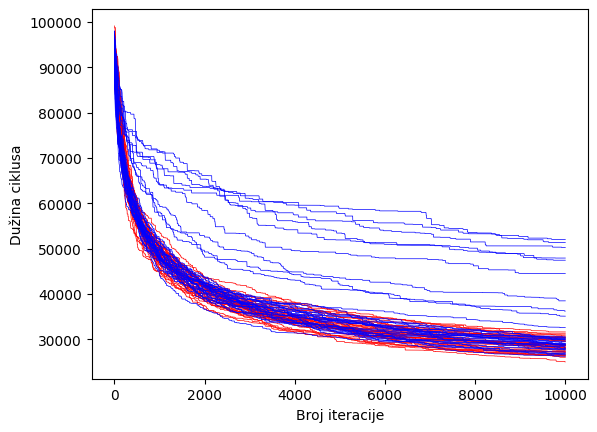

In [22]:
fig, ax = plt.subplots()
for T in np.linspace(1, 20000, 40):
    fastQatar = SimulatedAnnealing(qa)
    start = timeit.default_timer()
    fastQatarRes = fastQatar.optimize(num_iters=10000, T0=T, fast_annealing=True, end_fitness=0)
    stop = timeit.default_timer()
    print(f'============T={T}==========================')
    print(f'Best cycle:{fastQatar.cycle}\nBest fitness:{fastQatar.fitness}\nTime:{stop-start}')
    ax.plot(range(len(fastQatarRes)), fastQatarRes, color = 'red', lw=0.5)
    
for trs in (0.00001, 0.0001, 0.001, 0.01):
    for tas in (10, 100, 1000):
        for rr in (10, 30, 50):
            
            adaptiveQatar = AdaptiveSimulatedAnnealing(qa)
            adaptiveQatar.reannealingRate = rr
            adaptiveQatar.temperature_ratio_scale = trs
            adaptiveQatar.temperature_anneal_scale = tas
            adaptiveQatar.calculatec()
            adaptiveQatar.maxIters = 10000
            start = timeit.default_timer()
            adaptiveQatarRes = adaptiveQatar.optimize(end_fitness=0)
            stop = timeit.default_timer()
            print(f'=======trs {trs}===tas {tas}=====rr {rr}================')
            print(f'Best cycle:{adaptiveQatar.cycle}\nBest fitness:{adaptiveQatar.fitness}\nTime:{stop-start}')
            ax.plot(range(len(adaptiveQatarRes)), adaptiveQatarRes, color = 'blue', lw=0.5)

ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')

plt.show()